<a href="https://colab.research.google.com/github/rninurazizah/Heart_Disease-Paper/blob/main/final_eksperimen_gridSeacrh_ParalyzeAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Skripsi Maharani Nurazizah
#cv gridseacrh 10
# mean threshold fisher score
# Date: 2026-01-03

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pra Pemrosesan

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)

In [36]:
import pandas as pd
from google.colab import files

# ==============================================================================
# 1. LOAD DATA & DEDUPLIKASI (DEDUP)
# ==============================================================================
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Heart_Disease-Paper-main/dataset.csv')

# 1. Hitung jumlah data awal
jumlah_awal = len(df)
print(f"Jumlah data awal: {jumlah_awal} baris")

# 2. Hitung jumlah baris yang duplikat
jumlah_duplikat = df.duplicated().sum()
print(f"Jumlah data yang duplikat: {jumlah_duplikat} baris")

# 3. Lakukan penghapusan
df.drop_duplicates(inplace=True)

# 4. Tampilkan hasil akhir
jumlah_akhir = len(df)
print(f"Jumlah data setelah hapus duplikat: {jumlah_akhir} baris")

# Validasi (Opsional)
print(f"Total baris yang berhasil dibersihkan: {jumlah_awal - jumlah_akhir}")
# Pisahkan Nama Kolom

num_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

cat_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

y_all = df['target'].values

# ==============================================================================
# 2. SIMPAN & DOWNLOAD
# ==============================================================================
# Simpan ke file lokal di sistem Colab
nama_file = 'dataset_heart_clean.csv'
df.to_csv(nama_file, index=False)

# Download file ke komputer Anda
files.download(nama_file)

Jumlah data awal: 1025 baris
Jumlah data yang duplikat: 723 baris
Jumlah data setelah hapus duplikat: 302 baris
Total baris yang berhasil dibersihkan: 723


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
missing_values = df.isnull().sum()
total_missing = missing_values.sum()

if total_missing > 0:

    print(missing_values[missing_values > 0])
    print(f"\nmissing value: {total_missing}")
else:
    print(total_missing)

0


In [38]:
print(df.describe())

             age         sex          cp    trestbps        chol         fbs  \
count  302.00000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean    54.42053    0.682119    0.963576  131.602649  246.500000    0.149007   
std      9.04797    0.466426    1.032044   17.563394   51.753489    0.356686   
min     29.00000    0.000000    0.000000   94.000000  126.000000    0.000000   
25%     48.00000    0.000000    0.000000  120.000000  211.000000    0.000000   
50%     55.50000    1.000000    1.000000  130.000000  240.500000    0.000000   
75%     61.00000    1.000000    2.000000  140.000000  274.750000    0.000000   
max     77.00000    1.000000    3.000000  200.000000  564.000000    1.000000   

          restecg     thalach       exang     oldpeak       slope          ca  \
count  302.000000  302.000000  302.000000  302.000000  302.000000  302.000000   
mean     0.526490  149.569536    0.327815    1.043046    1.397351    0.718543   
std      0.526027   22.903527    0.4

## **BOXPLOT**





Statistik Deskriptif Lengkap:


,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
trestbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
thalach,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2
sex,302.0,0.682119,0.466426,0.0,0.00,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.00,1.0,2.00,3.0
fbs,302.0,0.149007,0.356686,0.0,0.00,0.0,0.00,1.0
restecg,302.0,0.526490,0.526027,0.0,0.00,1.0,1.00,2.0
exang,302.0,0.327815,0.470196,0.0,0.00,0.0,1.00,1.0


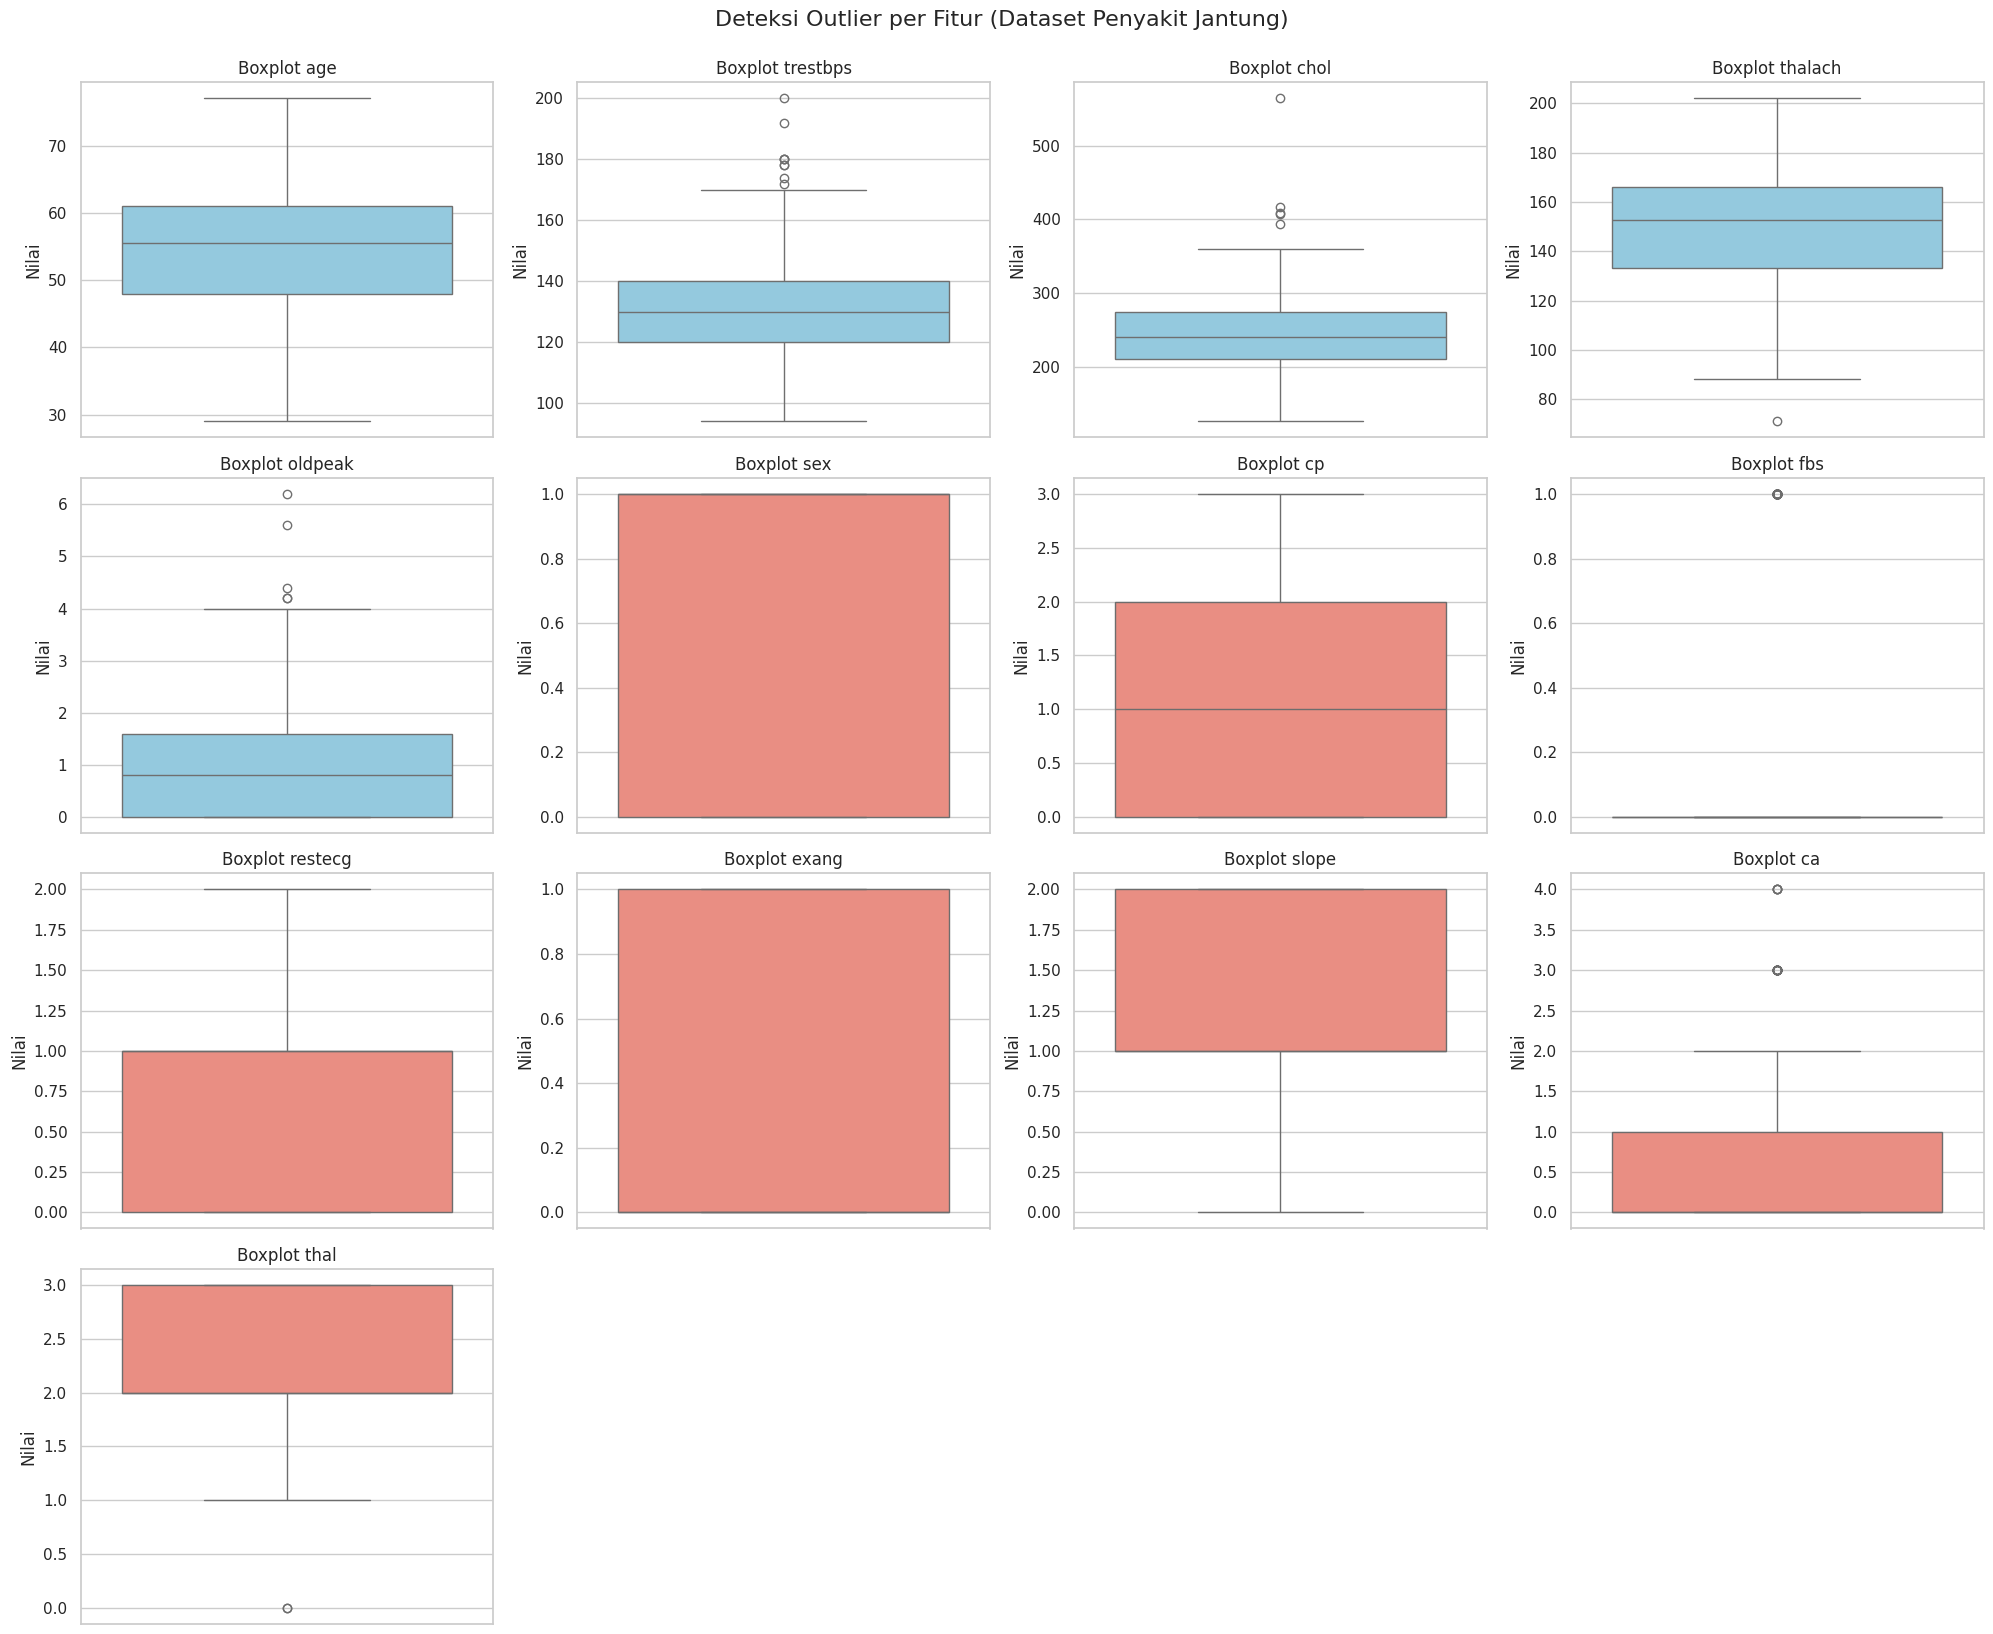

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns


# Gabungkan semua kolom yang ingin diinspeksi
all_inspect_cols = num_cols + cat_cols
n_cols = len(all_inspect_cols)

# Tentukan jumlah baris dan kolom untuk grid (misal 4 kolom per baris)
ncols_grid = 4
nrows_grid = (n_cols // ncols_grid) + (1 if n_cols % ncols_grid > 0 else 0)

# Buat Figure
plt.figure(figsize=(20, nrows_grid * 4))
sns.set(style="whitegrid")

for i, col in enumerate(all_inspect_cols):
    plt.subplot(nrows_grid, ncols_grid, i + 1)

    # Gunakan warna berbeda untuk numerik dan kategorikal
    color = "skyblue" if col in num_cols else "salmon"

    sns.boxplot(y=df[col], color=color)
    plt.title(f'Boxplot {col}', fontsize=12)
    plt.ylabel('Nilai')

plt.tight_layout()
plt.suptitle('Deteksi Outlier per Fitur (Dataset Penyakit Jantung)', fontsize=16, y=1.02)

# Statistik deskriptif tetap ditampilkan di konsol
print("\nStatistik Deskriptif Lengkap:")
display(df[all_inspect_cols].describe().T)

plt.show()

## Penanganan Outlier Data **Numerik** **bold text**

---



In [40]:
# 1. Inisialisasi dictionary untuk menyimpan kolom penyebab outlier per baris
# Key: index baris, Value: list nama kolom
row_outlier_map = {}

for col in num_cols:
    # Hitung Kuartil dan IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Tentukan Batas
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Ambil index baris yang nilainya di luar batas pada kolom ini
    temp_outliers = df[(df[col] < lower_limit) | (df[col] > upper_limit)].index

    # Simpan nama kolom ke setiap index yang terdeteksi
    for idx in temp_outliers:
        if idx not in row_outlier_map:
            row_outlier_map[idx] = []
        row_outlier_map[idx].append(col)

# 2. Filter DataFrame
df_outliers_only = df.loc[list(row_outlier_map.keys())].copy()

# 3. Tambahkan kolom keterangan kolom mana saja yang outlier
df_outliers_only['Outlier_In_Columns'] = df_outliers_only.index.map(lambda x: ", ".join(row_outlier_map[x]))

# 4. Tampilkan hasil dengan kolom keterangan di paling depan agar mudah dibaca
cols_to_show = ['Outlier_In_Columns'] + [c for c in df_outliers_only.columns if c != 'Outlier_In_Columns']
df_outliers_only = df_outliers_only[cols_to_show]

print(f"--- DAFTAR BARIS DENGAN KETERANGAN KOLOM OUTLIER (Total: {len(df_outliers_only)} baris) ---")
if len(df_outliers_only) > 0:
    display(df_outliers_only)
else:
    print("Tidak ditemukan baris dengan outlier.")

--- DAFTAR BARIS DENGAN KETERANGAN KOLOM OUTLIER (Total: 19 baris) ---


,Outlier_In_Columns,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
29,trestbps,55,0,0,180,327,0,2,117,1,3.4,1,0,2,0
47,trestbps,66,0,0,178,228,1,1,165,1,1.0,1,2,3,0
87,trestbps,59,0,0,174,249,0,1,143,1,0.0,1,0,2,0
137,trestbps,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
151,trestbps,54,1,1,192,283,0,0,195,0,0.0,2,1,3,0
175,trestbps,56,0,0,200,288,1,0,133,1,4.0,0,2,3,0
343,trestbps,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
396,trestbps,68,1,2,180,274,1,0,150,1,1.6,1,0,3,0
528,"trestbps, oldpeak",59,1,3,178,270,0,0,145,0,4.2,0,0,3,1
123,chol,65,0,2,140,417,1,0,157,0,0.8,2,1,2,1


## **Penanganan Outlier Data Kategrikal**

In [41]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

# 1. Definisi Rentang Valid (Standar UCI)
kategori_valid = {
    'ca': [0, 1, 2, 3],
    'thal': [1, 2, 3]
}

print(">>> Menganalisis data kategorikal untuk imputasi median...")

# Ubah nilai yang tidak valid menjadi NaN
for col, valid_values in kategori_valid.items():
    df.loc[~df[col].isin(valid_values), col] = np.nan

# Simpan informasi missing value untuk laporan
missing_info = df[['ca', 'thal']].isnull().sum()
print("Fitur dengan missing value:")
print(missing_info[missing_info > 0])
print()

# Simpan lokasi NaN untuk tabel perbandingan
missing_map = []
null_indices = df[df[['ca', 'thal']].isnull().any(axis=1)].index
for idx in null_indices:
    for col in ['ca', 'thal']:
        if pd.isnull(df.loc[idx, col]):
            missing_map.append({'index': idx, 'fitur': col})

# Explanation for "Jumlah Fitur Awal : 20" before PCA:
# This refers to the number of features after one-hot encoding categorical variables.
# Let's count them:

# Numerical features
num_features_count = len(num_cols)
print(f"\nJumlah fitur numerik (num_cols): {num_features_count}")

# Categorical features after one-hot encoding (drop_first=True)
# This is done before PCA, as seen in cell YUbxP59ifaYf:
# `df_encoded = pd.get_dummies(df[all_cols_for_encoding], columns=[c for c in cat_cols if c in df.columns], drop_first=True)`


>>> Menganalisis data kategorikal untuk imputasi median...
Fitur dengan missing value:
ca      4
thal    2
dtype: int64


Jumlah fitur numerik (num_cols): 5


In [42]:
print(">>> Memulai proses imputasi dengan Median (Simple Imputation)...\n")

# Inisialisasi SimpleImputer dengan strategi Median
# Median akan mengambil nilai tengah dari seluruh data yang valid di kolom tersebut
imputer_median = SimpleImputer(strategy='median')

# Proses Imputasi pada kolom ca dan thal
df[['ca', 'thal']] = imputer_median.fit_transform(df[['ca', 'thal']])

# Pastikan hasil imputasi dibulatkan dan diubah ke integer
# (Penting jika median menghasilkan nilai .5)
df['ca'] = df['ca'].round().astype(int)
df['thal'] = df['thal'].round().astype(int)

# --- Cetak Tabel Laporan Sesuai Format ---
print("=================================================================")
print(f"{'INDEX':<7} | {'FITUR':<12} | {'STATUS ASAL':<20} | {'HASIL IMPUTASI'}")
print("=================================================================")

for item in missing_map:
    idx = item['index']
    col = item['fitur']
    val_imputed = df.loc[idx, col]
    print(f"{idx:<7} | {col:<12} | {'NaN (Outlier)':<20} | -> {int(val_imputed)}")

print("=================================================================")
print(f"Total Nilai Yang Berjaya Diimputasi : {len(missing_map)}")
print(f"Total Missing Value Sekarang        : {df[['ca', 'thal']].isnull().sum().sum()}")

>>> Memulai proses imputasi dengan Median (Simple Imputation)...

INDEX   | FITUR        | STATUS ASAL          | HASIL IMPUTASI
14      | thal         | NaN (Outlier)        | -> 2
52      | ca           | NaN (Outlier)        | -> 0
128     | ca           | NaN (Outlier)        | -> 0
319     | thal         | NaN (Outlier)        | -> 2
348     | ca           | NaN (Outlier)        | -> 0
521     | ca           | NaN (Outlier)        | -> 0
Total Nilai Yang Berjaya Diimputasi : 6
Total Missing Value Sekarang        : 0


In [43]:
print("\nContoh data setelah imputasi median:")
display(df.head().astype(int))

# Pastikan kolom target juga tetap integer
if 'target' in df.columns:
    df['target'] = df['target'].astype(int)


Contoh data setelah imputasi median:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1,1,3,2,0


In [44]:
# Simpan data yang sudah diimputasi KNN untuk keperluan analisis
df.to_csv('dataset_heart_imputed_knn.csv', index=False)
y_all = df['target'].values

In [45]:
# List fitur dan rentang validnya
kategori_valid = {
    'sex': [0, 1],
    'cp': [0, 1, 2, 3],
    'fbs': [0, 1],
    'restecg': [0, 1, 2],
    'exang': [0, 1],
    'slope': [0, 1, 2],
    'ca': [0, 1, 2, 3],
    'thal': [1, 2, 3]
}

print("--- LAPORAN DATA KATEGORIKAL TIDAK VALID (df_final) ---")
for col, valid_range in kategori_valid.items():
    # Check df_final instead of df
    anomali_final = df[~df[col].isin(valid_range)]
    if not anomali_final.empty:
        print(f"Fitur '{col}': Terdeteksi {len(anomali_final)} baris dengan nilai tidak valid: {anomali_final[col].unique()}")
    else:
        print(f"Fitur '{col}': Bersih (Semua data sesuai rentang)")

--- LAPORAN DATA KATEGORIKAL TIDAK VALID (df_final) ---
Fitur 'sex': Bersih (Semua data sesuai rentang)
Fitur 'cp': Bersih (Semua data sesuai rentang)
Fitur 'fbs': Bersih (Semua data sesuai rentang)
Fitur 'restecg': Bersih (Semua data sesuai rentang)
Fitur 'exang': Bersih (Semua data sesuai rentang)
Fitur 'slope': Bersih (Semua data sesuai rentang)
Fitur 'ca': Bersih (Semua data sesuai rentang)
Fitur 'thal': Bersih (Semua data sesuai rentang)


## **EDA setelah Cleaning**


Statistik Deskriptif Lengkap:


,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
trestbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
thalach,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2
sex,302.0,0.682119,0.466426,0.0,0.00,1.0,1.00,1.0
cp,302.0,0.963576,1.032044,0.0,0.00,1.0,2.00,3.0
fbs,302.0,0.149007,0.356686,0.0,0.00,0.0,0.00,1.0
restecg,302.0,0.526490,0.526027,0.0,0.00,1.0,1.00,2.0
exang,302.0,0.327815,0.470196,0.0,0.00,0.0,1.00,1.0


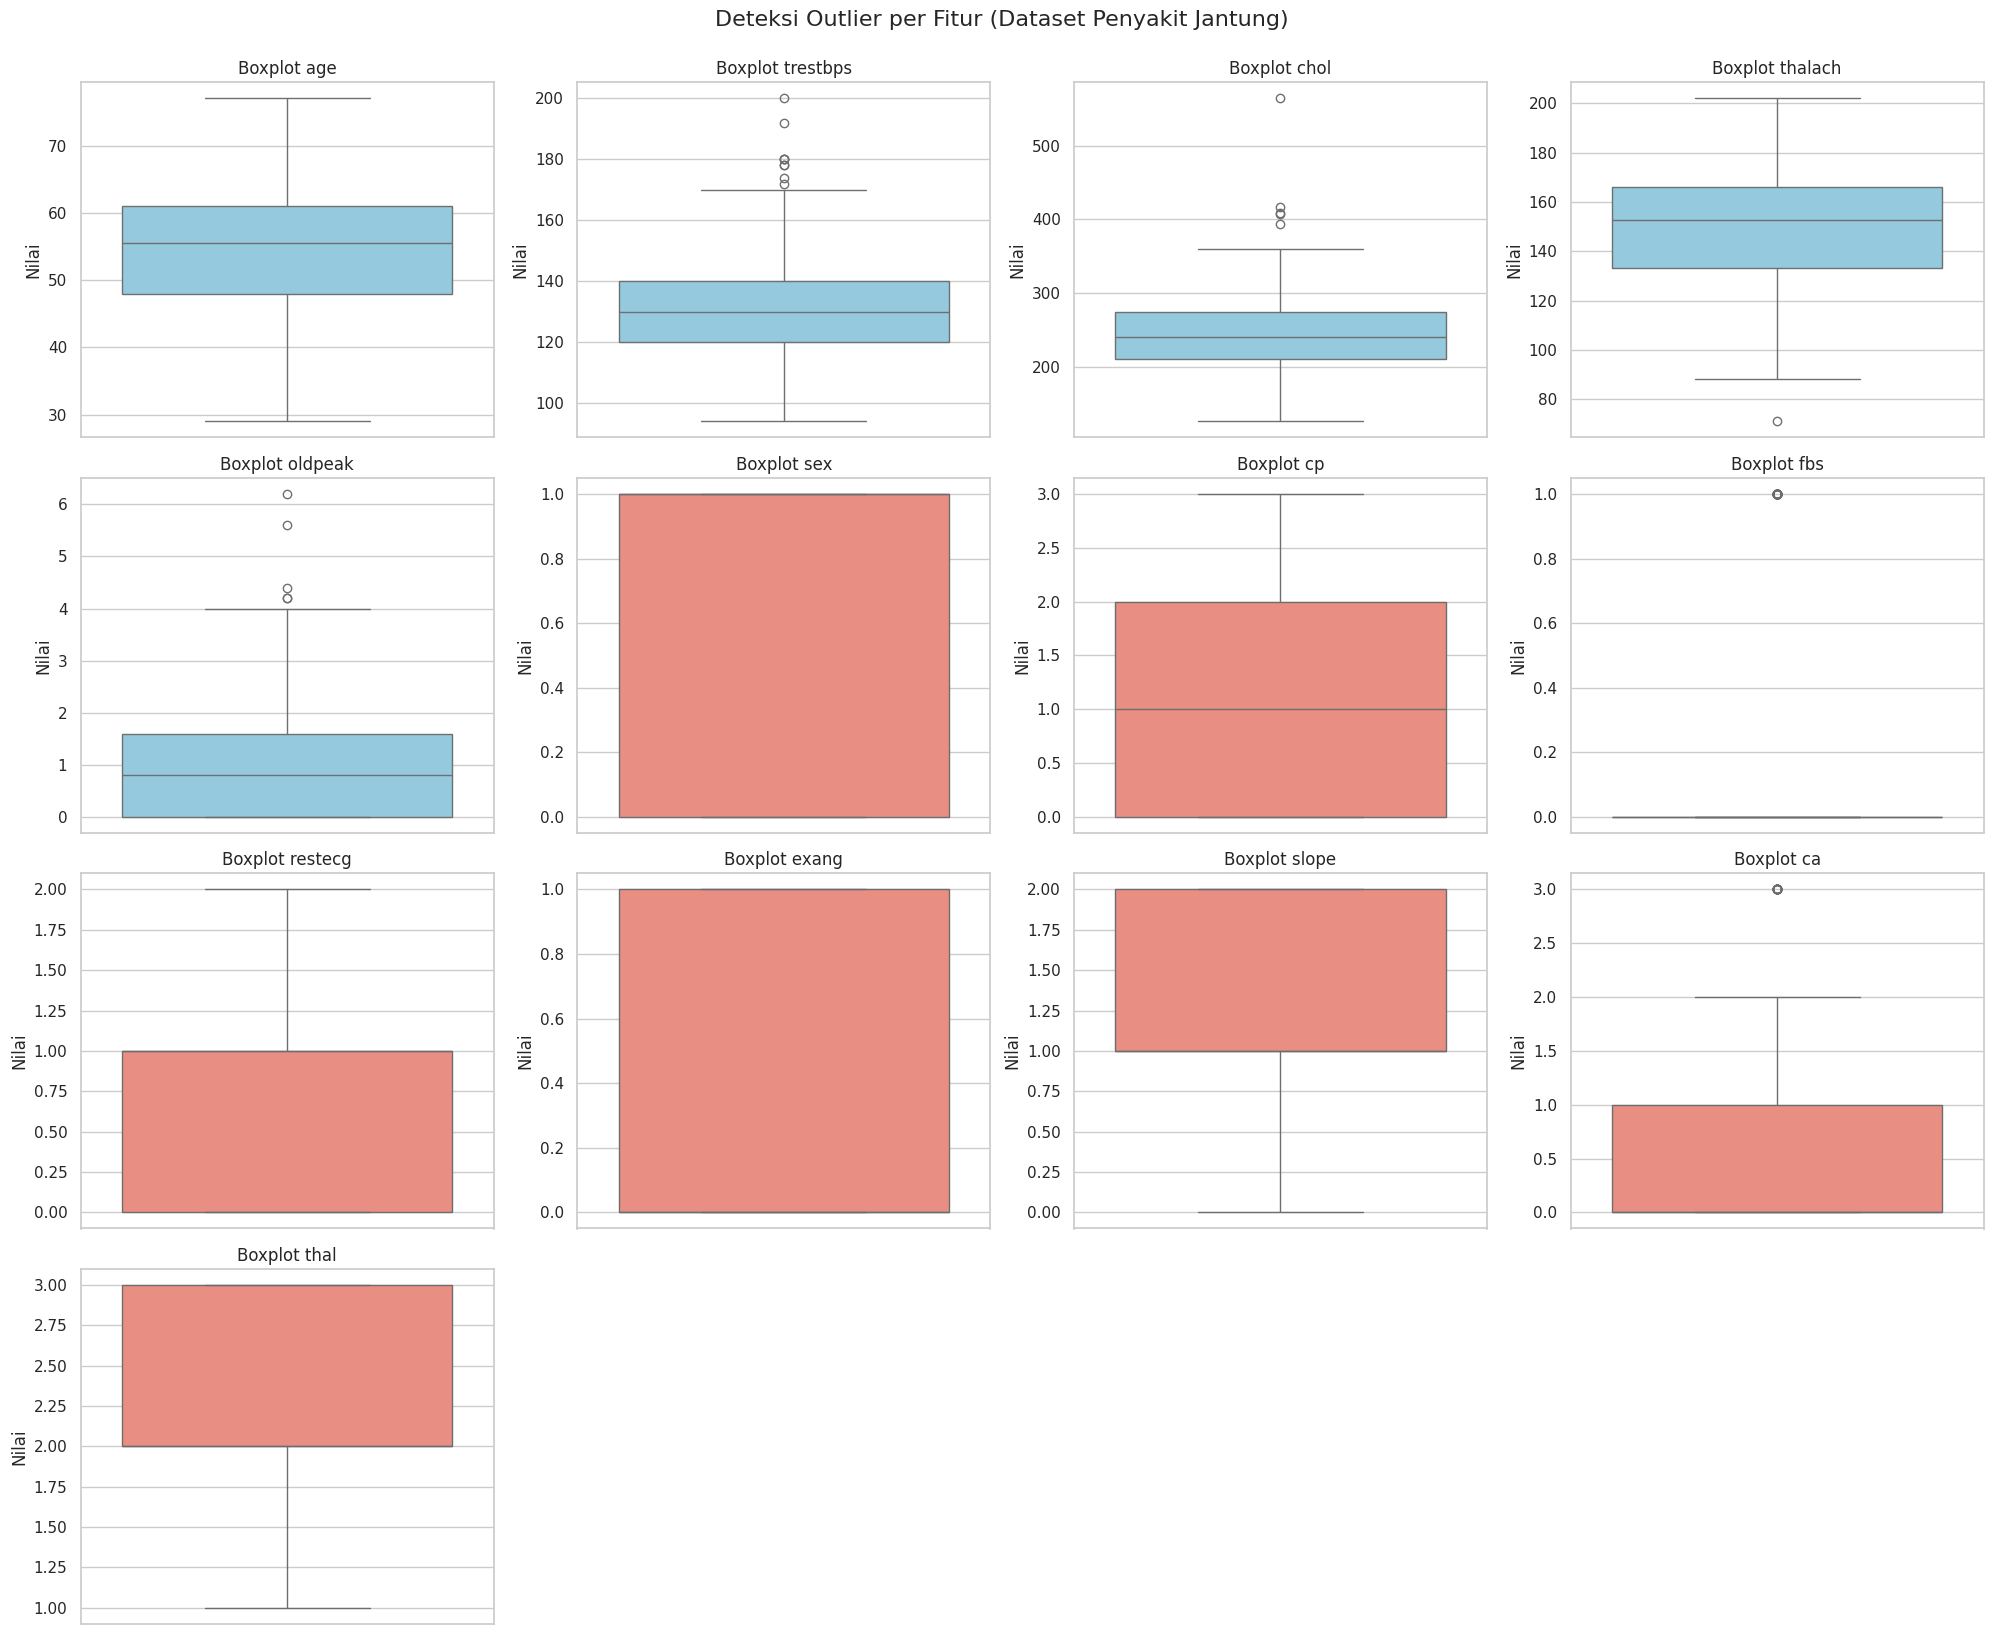

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns


# Gabungkan semua kolom yang ingin diinspeksi
all_inspect_cols = num_cols + cat_cols
n_cols = len(all_inspect_cols)

# Tentukan jumlah baris dan kolom untuk grid (misal 4 kolom per baris)
ncols_grid = 4
nrows_grid = (n_cols // ncols_grid) + (1 if n_cols % ncols_grid > 0 else 0)

# Buat Figure
plt.figure(figsize=(20, nrows_grid * 4))
sns.set(style="whitegrid")

for i, col in enumerate(all_inspect_cols):
    plt.subplot(nrows_grid, ncols_grid, i + 1)

    # Gunakan warna berbeda untuk numerik dan kategorikal
    color = "skyblue" if col in num_cols else "salmon"

    sns.boxplot(y=df[col], color=color)
    plt.title(f'Boxplot {col}', fontsize=12)
    plt.ylabel('Nilai')

plt.tight_layout()
plt.suptitle('Deteksi Outlier per Fitur (Dataset Penyakit Jantung)', fontsize=16, y=1.02)

# Statistik deskriptif tetap ditampilkan di konsol
print("\nStatistik Deskriptif Lengkap:")
display(df[all_inspect_cols].describe().T)

plt.show()

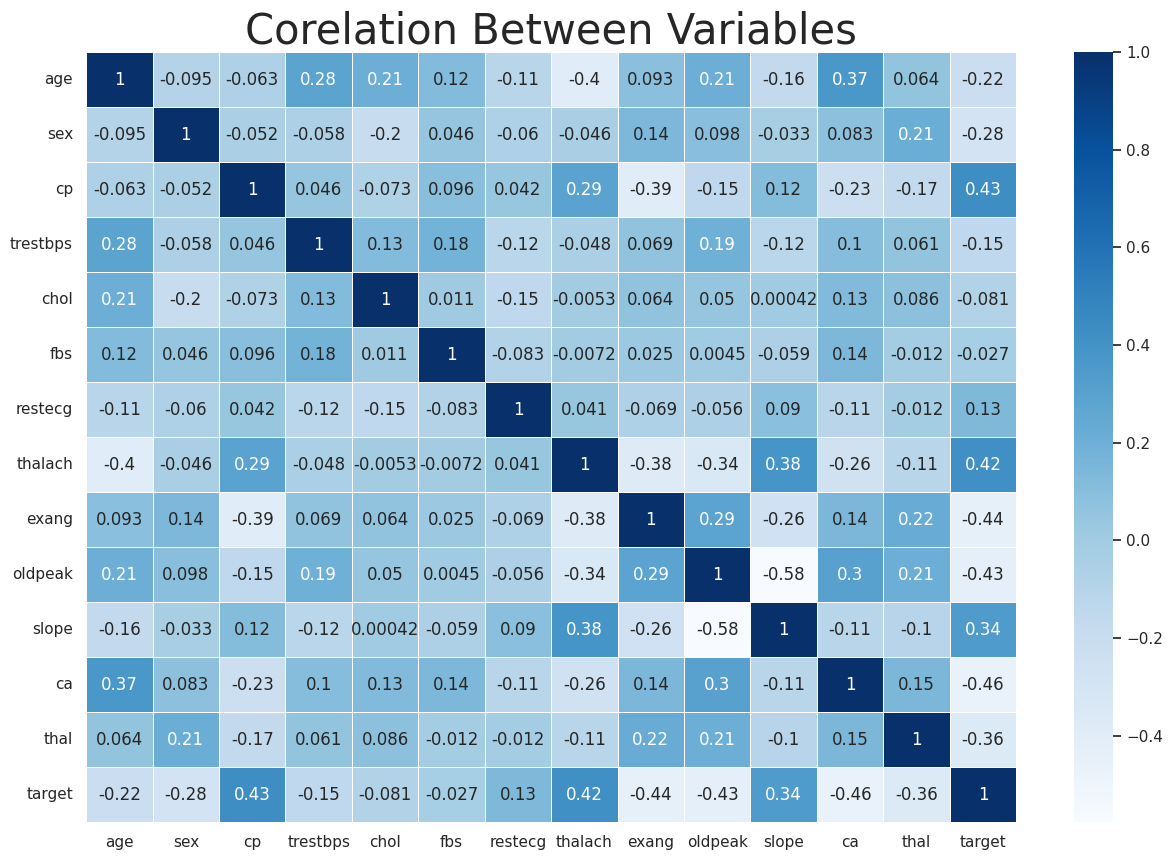

In [47]:
sns.set(style="white")
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df.corr(), annot = True, linewidths=.5, cmap="Blues")
plt.title('Corelation Between Variables', fontsize = 30)
plt.show()

#  FITUR SELEKSI

## **FISHER SCORE**

Nilai Rata-rata Fisher Score (Threshold Beta): 0.1032
Jumlah Fitur Awal: 5
Jumlah Fitur Terpilih (>= Rata-rata): 2


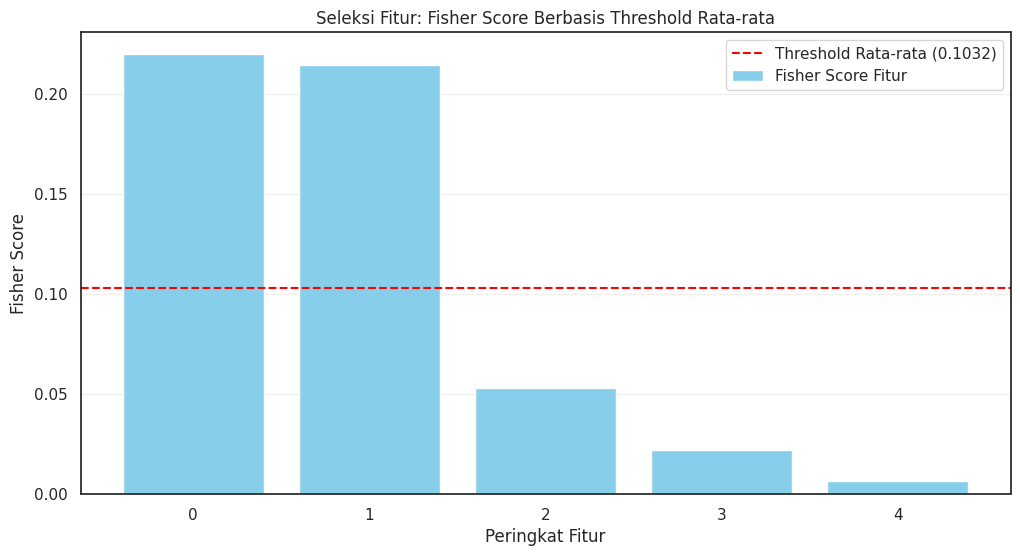

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Fungsi Fisher Score (Sesuai Jurnal Singh 2014 [cite: 104-106])
def fisher_calc(feat, y_v):
    m = np.mean(feat)
    m0, m1 = np.mean(feat[y_v==0]), np.mean(feat[y_v==1])
    v0, v1 = np.var(feat[y_v==0]), np.var(feat[y_v==1])
    # Menghitung seberapa baik fitur memisahkan antar kelas
    return ((m0-m)**2 + (m1-m)**2) / (v0+v1) if (v0+v1) != 0 else 0

# --- PROSES PERHITUNGAN DAN SELEKSI ---

# Hitung Fisher Score untuk semua fitur
scores_list = [fisher_calc(df[col].values, y_all) for col in num_cols]

# Simpan ke DataFrame
fisher_df = pd.DataFrame({
    'Fitur': num_cols,
    'Fisher_Score': scores_list
})

# 2. Menentukan Threshold Berdasarkan Rata-rata Fisher Score
beta_threshold = fisher_df['Fisher_Score'].mean()

# 3. Seleksi Fitur (Fitur yang nilainya >= Rata-rata)
df_selected = fisher_df[fisher_df['Fisher_Score'] >= beta_threshold].copy()
df_selected = df_selected.sort_values(by='Fisher_Score', ascending=False).reset_index(drop=True)

selected_features = df_selected['Fitur'].tolist()

print(f"Nilai Rata-rata Fisher Score (Threshold Beta): {beta_threshold:.4f}")
print(f"Jumlah Fitur Awal: {len(num_cols)}")
print(f"Jumlah Fitur Terpilih (>= Rata-rata): {len(selected_features)}")

# --- VISUALISASI UNTUK BAB 4 ---
plt.figure(figsize=(12, 6))
sorted_all = fisher_df.sort_values(by='Fisher_Score', ascending=False)

plt.bar(range(len(sorted_all)), sorted_all['Fisher_Score'], color='skyblue', label='Fisher Score Fitur')
plt.axhline(y=beta_threshold, color='red', linestyle='--',
            label=f'Threshold Rata-rata ({beta_threshold:.4f})')

plt.title('Seleksi Fitur: Fisher Score Berbasis Threshold Rata-rata')
plt.xlabel('Peringkat Fitur')
plt.ylabel('Fisher Score')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## **MUTUAL INFORMATION**

In [49]:
import numpy as np

def get_mi_threshold_by_permutation(df, cat_cols, y, n_permutations=1000):
    print(f"Menghitung threshold dengan {n_permutations} kali permutasi...")

    all_permuted_scores = []

    for i in range(n_permutations):
        # Permutasi target (mengacak label y)
        y_permuted = np.random.permutation(y)

        # Hitung MI dengan target yang sudah diacak
        permuted_scores = mutual_info_classif(df[cat_cols], y_permuted, discrete_features=True, random_state=i)
        all_permuted_scores.extend(permuted_scores)

    # Threshold ditentukan dari percentile ke-95 dari skor acak
    # Artinya, hanya ada 5% kemungkinan skor fitur asli muncul karena faktor kebetulan
    threshold = np.percentile(all_permuted_scores, 95)

    return threshold

# --- Implementasi dalam fungsi Anda ---

# 1. Cari threshold otomatis dulu
dynamic_threshold = get_mi_threshold_by_permutation(df, cat_cols, y_all)

# 2. Masukkan ke fungsi Anda
def get_mi_ranking_with_dynamic_threshold(df, cat_cols, y, threshold):
    mi_scores = mutual_info_classif(df[cat_cols], y, discrete_features=True, random_state=42)

    mi_df = pd.DataFrame({
        'Fitur Kategorikal': cat_cols,
        'MI_Score': mi_scores
    }).sort_values(by='MI_Score', ascending=False).reset_index(drop=True)

    selected_mi = mi_df[mi_df['MI_Score'] > threshold]['Fitur Kategorikal'].tolist()

    print(f"\nThreshold MI (Permutation Result): > {threshold:.5f}")
    print(f"Fitur Terpilih: {selected_mi}")

    return selected_mi, mi_df

cols_mi_selected, mi_ranking_table = get_mi_ranking_with_dynamic_threshold(df, cat_cols, y_all, dynamic_threshold)

Menghitung threshold dengan 1000 kali permutasi...

Threshold MI (Permutation Result): > 0.01047
Fitur Terpilih: ['thal', 'cp', 'ca', 'exang', 'slope', 'sex', 'restecg']



--- TABEL SKOR MUTUAL INFORMATION (KATEGORIKAL) ---
  Fitur Kategorikal  MI_Score
0              thal  0.145851
1                cp  0.141042
2                ca  0.128140
3             exang  0.098085
4             slope  0.080175
5               sex  0.041769
6           restecg  0.016254
7               fbs  0.000359


/tmp/ipython-input-2572451234.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI_Score', y='Fitur Kategorikal', data=mi_ranking_table, palette=colors)


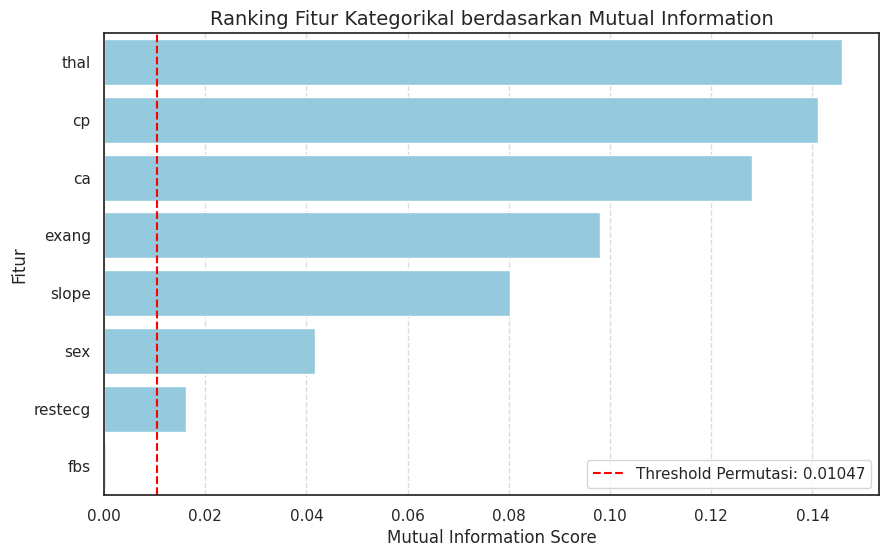

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

# Menampilkan Tabel Ranking MI
print("\n--- TABEL SKOR MUTUAL INFORMATION (KATEGORIKAL) ---")
print(mi_ranking_table)

# Visualisasi Ranking Fitur
plt.figure(figsize=(10, 6))
colors = ['skyblue' if score > dynamic_threshold else 'lightgrey' for score in mi_ranking_table['MI_Score']]
sns.barplot(x='MI_Score', y='Fitur Kategorikal', data=mi_ranking_table, palette=colors)

# Menambahkan Garis Threshold Permutasi
plt.axvline(x=dynamic_threshold, color='red', linestyle='--', label=f'Threshold Permutasi: {dynamic_threshold:.5f}')

plt.title('Ranking Fitur Kategorikal berdasarkan Mutual Information', fontsize=14)
plt.xlabel('Mutual Information Score', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## **PCA**

In [75]:
# 1. Klasifikasi Ulang Kolom
# Pisahkan nominal murni yang butuh One-Hot Encoding
nominal_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'thal']
# Masukkan ordinal ke dalam list numerik agar hanya terkena Scaling
num_and_ordinal_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']

# 2. Proses Encoding & Scaling Terintegrasi
# Hanya nominal_cols yang dibuatkan dummies
X_enc = pd.get_dummies(df.drop('target', axis=1), columns=nominal_cols, drop_first=True)

# 3. Scaling (Semua fitur sekarang sudah numerik)
sc = StandardScaler()
X_scaled = sc.fit_transform(X_enc)

# Simpan jumlah fitur setelah encoding untuk Analisis Paralel
n_features_final = X_enc.shape[1]
print(f"Jumlah fitur final untuk PCA: {n_features_final}")

print(f"Jumlah fitur awal: {X_raw.shape[1]}")
print(f"Jumlah fitur setelah Encoding: {X_enc.shape[1]} (Ini yang akan diolah PCA)")

n_samples, n_features = X_scaled.shape
n_iterations = 1000

# A. Eigenvalue Asli
pca_real = PCA().fit(X_scaled)
real_eigenvalues = pca_real.explained_variance_

# B. Simulasi Eigenvalue Acak
print(f"Menghitung threshold dengan {n_iterations} kali simulasi data acak...")
all_rand_eigen = []
for i in range(n_iterations):
    X_random = np.random.normal(0, 1, size=(n_samples, n_features))
    pca_rand = PCA().fit(X_random)
    all_rand_eigen.append(pca_rand.explained_variance_)

# Ambil Persentil 95 sebagai batas ketat
thresholds = np.percentile(all_rand_eigen, 95, axis=0)

# C. Hitung Varians Kumulatif
exp_var_ratio = pca_real.explained_variance_ratio_
cum_var_ratio = np.cumsum(exp_var_ratio)

# D. Buat Tabel Summary
pca_ranking_table = pd.DataFrame({
    'Component': [f"PC{i+1}" for i in range(n_features)],
    'Eigenvalue_Asli': real_eigenvalues,
    'Threshold_P95': thresholds,
    'Variance_Ratio': exp_var_ratio,
    'Cumulative_Variance': cum_var_ratio,
    'Status': ['Terpilih' if a > t else 'Dibuang' for a, t in zip(real_eigenvalues, thresholds)]
})

# Menampilkan hasil
display(pca_ranking_table)

# E. Ringkasan Akhir
k_opt = np.sum(pca_ranking_table['Status'] == 'Terpilih')
print("-" * 50)
print(f"Hasil Analisis Paralel:")
print(f"Jumlah Komponen yang Lolos Seleksi: {k_opt}")
print(f"Total Informasi (Varians) yang Dipertahankan: {pca_ranking_table.loc[k_opt-1, 'Cumulative_Variance']:.4%}")

Jumlah fitur final untuk PCA: 17
Jumlah fitur awal: 13
Jumlah fitur setelah Encoding: 17 (Ini yang akan diolah PCA)
Menghitung threshold dengan 1000 kali simulasi data acak...


,Component,Eigenvalue_Asli,Threshold_P95,Variance_Ratio,Cumulative_Variance,Status
0,PC1,3.529078,1.563099,0.206905,0.206905,Terpilih
1,PC2,1.818221,1.449773,0.106600,0.313505,Terpilih
2,PC3,1.343534,1.363397,0.078770,0.392275,Dibuang
3,PC4,1.314301,1.290977,0.077056,0.469331,Terpilih
4,PC5,1.249676,1.229731,0.073267,0.542598,Terpilih
5,PC6,1.017795,1.174615,0.059672,0.602270,Dibuang
6,PC7,0.935778,1.123991,0.054863,0.657133,Dibuang
7,PC8,0.929194,1.073161,0.054478,0.711611,Dibuang
8,PC9,0.896650,1.033114,0.052569,0.764180,Dibuang
9,PC10,0.806864,0.984424,0.047305,0.811486,Dibuang


--------------------------------------------------
Hasil Analisis Paralel:
Jumlah Komponen yang Lolos Seleksi: 4
Total Informasi (Varians) yang Dipertahankan: 46.9331%


In [77]:
def preprocess_experiment(df_train, df_test, y_train, cols_num_ord, cols_nominal, is_pca, estimator_obj):
    # Pisahkan fitur target
    X_tr_raw = df_train.drop(columns=['target'], errors='ignore')
    X_te_raw = df_test.drop(columns=['target'], errors='ignore')

    if is_pca:
        # --- JALUR PCA: WAJIB ENCODING (Menjadi 17+ kolom) ---
        X_tr_enc = pd.get_dummies(X_tr_raw, columns=cols_nominal, drop_first=True)
        X_te_enc = pd.get_dummies(X_te_raw, columns=cols_nominal, drop_first=True)
        X_te_enc = X_te_enc.reindex(columns=X_tr_enc.columns, fill_value=0)

        sc = StandardScaler()
        X_tr_s = sc.fit_transform(X_tr_enc)
        X_te_s = sc.transform(X_te_enc)

        pca = PCA(n_components=k_opt)
        X_tr_final = pca.fit_transform(X_tr_s)
        X_te_final = pca.transform(X_te_s)
        n_feat = pca.n_components_

    else:
        # --- JALUR NON-PCA: TETAP FITUR ASLI (13 Kolom) ---
        # Kita hanya melakukan Scaling tanpa memecah kolom (One-Hot)
        # Model seperti XGBoost/ETC sangat kuat menangani data seperti ini
        sc = StandardScaler()
        X_tr_final = sc.fit_transform(X_tr_raw)
        X_te_final = sc.transform(X_te_raw)
        n_feat = X_tr_raw.shape[1]

    return X_tr_final, X_te_final, n_feat

# **IMPLEMENTATION**

In [53]:
def calculate_metrics(y_true, y_pred, y_prob):
    """Menghitung semua metrik evaluasi dalam satu dictionary."""
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'acc': accuracy_score(y_true, y_pred),
        'rec': recall_score(y_true, y_pred, zero_division=0),
        'pre': precision_score(y_true, y_pred, zero_division=0),
        'auc': roc_auc_score(y_true, y_prob),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn
    }

def append_to_log(log_list, s_name, m_name, config, n_feat, params, m_dict):
    """Menyimpan hasil rata-rata metrik ke results_log."""
    log_list.append({
        "Skenario": s_name, "Model": m_name, "Konfigurasi": config, "Σ Fitur": n_feat,
        "Best Param": str(Counter(params).most_common(1)[0][0]),
        "Acc": f"{np.mean(m_dict['acc']):.4f} (±{np.std(m_dict['acc']):.4f})",
        "Recall": f"{np.mean(m_dict['rec']):.4f}",
        "Precision": f"{np.mean(m_dict['pre']):.4f}",
        "AUC": f"{np.mean(m_dict['auc']):.4f}",
        "F1": f"{np.mean(m_dict['f1']):.4f}",
        "TP": sum(m_dict['tp']), "TN": sum(m_dict['tn']),
        "FP": sum(m_dict['fp']), "FN": sum(m_dict['fn'])
    })

In [78]:

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (accuracy_score, recall_score, precision_score,
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from collections import Counter

# --- 1. CONFIGURATION ---
param_grid_etc = {'n_estimators': [100, 200, 300]}
param_grid_xgb = {'n_estimators': [100, 200, 300]}

scenarios = {
    "Baseline": "all", "FS": "fs", "MI": "mi", "PCA": "pca",
    "FS+MI": "fs_mi", "FS+PCA": "fs_pca", "MI+PCA": "mi_pca"
}
model_names = ["ETC", "XGB", "Hybrid"]
ratio = float(np.sum(y_all == 0)) / np.sum(y_all == 1)

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results_log = []
roc_data_storage = {}

for s_name, s_type in scenarios.items():
    print(f"\n>>> Processing Scenario: {s_name}")

    # Inisialisasi Penampung
    is_pca = 'pca' in s_type
    num_feat = selected_features if 'fs' in s_type else num_cols
    cat_feat = cols_mi_selected if 'mi' in s_type else cat_cols

    # Storage metrik & ROC per skenario
    m_store = {m: {k: [] for k in ['acc','rec','pre','auc','f1','tp','tn','fp','fn']} for m in model_names}
    p_tracker = {m: [] for m in model_names}
    y_true_all, p_etc_all, p_xgb_all, p_hyb_all = [], [], [], []

    for tr_idx, te_idx in outer_cv.split(df, y_all):
        df_tr, df_te = df.iloc[tr_idx], df.iloc[te_idx]
        y_tr, y_te = y_all[tr_idx], y_all[te_idx]

        # 1. Preprocessing
        X_tr_etc, X_te_etc, n_f_etc = preprocess_experiment(df_tr, df_te, y_tr, num_feat, cat_feat, is_pca, 'etc')
        X_tr_xgb, X_te_xgb, n_f_xgb = preprocess_experiment(df_tr, df_te, y_tr, num_feat, cat_feat, is_pca, 'xgb')

        # 2. Model ETC
        grid_etc = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid_etc, cv=inner_cv).fit(X_tr_etc, y_tr)
        best_etc = grid_etc.best_estimator_
        prob_etc = best_etc.predict_proba(X_te_etc)[:, 1]
        res_etc = calculate_metrics(y_te, best_etc.predict(X_te_etc), prob_etc)
        for k, v in res_etc.items(): m_store['ETC'][k].append(v)
        p_tracker['ETC'].append(grid_etc.best_params_['n_estimators'])

        # 3. Model XGB
        grid_xgb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"), param_grid_xgb, cv=inner_cv).fit(X_tr_xgb, y_tr)
        best_xgb = grid_xgb.best_estimator_
        prob_xgb = best_xgb.predict_proba(X_te_xgb)[:, 1]
        res_xgb = calculate_metrics(y_te, best_xgb.predict(X_te_xgb), prob_xgb)
        for k, v in res_xgb.items(): m_store['XGB'][k].append(v)
        p_tracker['XGB'].append(grid_xgb.best_params_['n_estimators'])

        # 4. Model Hybrid (Stacking)
        # Train Meta-model (XGB) menggunakan fitur asli + prediksi ETC
        X_tr_hyb = np.column_stack((X_tr_xgb, best_etc.predict(X_tr_etc)))
        X_te_hyb = np.column_stack((X_te_xgb, best_etc.predict(X_te_etc)))

        grid_hyb = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss"), param_grid_xgb, cv=inner_cv).fit(X_tr_hyb, y_tr)
        best_hyb = grid_hyb.best_estimator_
        prob_hyb = best_hyb.predict_proba(X_te_hyb)[:, 1]
        res_hyb = calculate_metrics(y_te, best_hyb.predict(X_te_hyb), prob_hyb)
        for k, v in res_hyb.items(): m_store['Hybrid'][k].append(v)
        p_tracker['Hybrid'].append(f"E:{best_etc.n_estimators}|X:{best_hyb.n_estimators}")

        # Simpan untuk ROC
        y_true_all.extend(y_te); p_etc_all.extend(prob_etc); p_xgb_all.extend(prob_xgb); p_hyb_all.extend(prob_hyb)

    # Simpan Data ROC per skenario
    roc_data_storage[s_name] = {'y_true': y_true_all, 'prob_etc': p_etc_all, 'prob_xgb': p_xgb_all, 'prob_hyb': p_hyb_all}
    append_to_log(results_log, s_name, "ETC", "ExtraTrees Classifier", n_f_etc, p_tracker['ETC'], m_store['ETC'])
    append_to_log(results_log, s_name, "XGB", "XGBoost Classifier", n_f_xgb, p_tracker['XGB'], m_store['XGB'])
    append_to_log(results_log, s_name, "Hybrid", "Hybrid (ETC + XGB Stacking)", n_f_xgb+1, p_tracker['Hybrid'], m_store['Hybrid'])

# 3. Hasil Akhir
df_final_results = pd.DataFrame(results_log)
display(df_final_results)


>>> Processing Scenario: Baseline


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:11:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:11:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:11:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:11:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:11:44] WARNING: /w


>>> Processing Scenario: FS


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:05] WARNING: /w


>>> Processing Scenario: MI


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:24] WARNING: /w


>>> Processing Scenario: PCA


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:12:43] WARNING: /w


>>> Processing Scenario: FS+MI


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:04] WARNING: /w


>>> Processing Scenario: FS+PCA


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:25] WARNING: /w


>>> Processing Scenario: MI+PCA


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:13:45] WARNING: /w

,Skenario,Model,Konfigurasi,Σ Fitur,Best Param,Acc,Recall,Precision,AUC,F1,TP,TN,FP,FN
0,Baseline,ETC,ExtraTrees Classifier,13,300,0.8344 (±0.0106),0.8720,0.8332,0.9117,0.8510,143,109,29,21
1,Baseline,XGB,XGBoost Classifier,13,200,0.8180 (±0.0370),0.8473,0.8230,0.8779,0.8335,139,108,30,25
2,Baseline,Hybrid,Hybrid (ETC + XGB Stacking),14,E:300|X:100,0.8344 (±0.0106),0.8720,0.8332,0.8310,0.8510,143,109,29,21
3,FS,ETC,ExtraTrees Classifier,13,300,0.8344 (±0.0106),0.8720,0.8332,0.9117,0.8510,143,109,29,21
4,FS,XGB,XGBoost Classifier,13,200,0.8180 (±0.0370),0.8473,0.8230,0.8779,0.8335,139,108,30,25
5,FS,Hybrid,Hybrid (ETC + XGB Stacking),14,E:300|X:100,0.8344 (±0.0106),0.8720,0.8332,0.8310,0.8510,143,109,29,21
6,MI,ETC,ExtraTrees Classifier,13,300,0.8344 (±0.0106),0.8720,0.8332,0.9117,0.8510,143,109,29,21
7,MI,XGB,XGBoost Classifier,13,200,0.8180 (±0.0370),0.8473,0.8230,0.8779,0.8335,139,108,30,25
8,MI,Hybrid,Hybrid (ETC + XGB Stacking),14,E:300|X:100,0.8344 (±0.0106),0.8720,0.8332,0.8310,0.8510,143,109,29,21
9,PCA,ETC,ExtraTrees Classifier,4,100,0.7781 (±0.0198),0.7805,0.8146,0.8697,0.7893,128,107,31,36


# **EVALUATION**

## **METRIK KLASFIKASI**

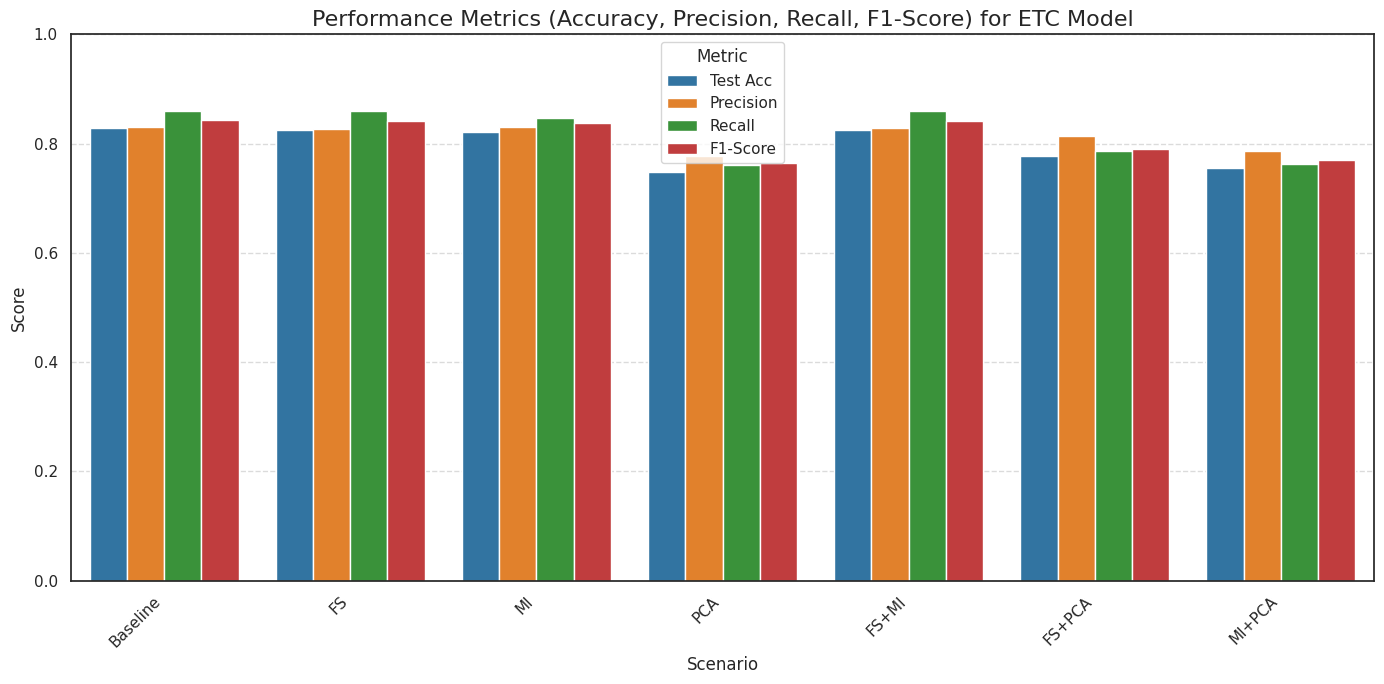

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Ensure 'Mean Acc' and 'Std Dev' columns are extracted if not already
if 'Mean Acc' not in df_final_results.columns or 'Std Dev' not in df_final_results.columns:
    def extract_mean_std(acc_str):
        match = re.match(r'([\d.]+) \(±([\d.]+)\)', acc_str)
        if match:
            return float(match.group(1)), float(match.group(2))
        return None, None
    df_final_results[['Mean Acc', 'Std Dev']] = df_final_results['Acc'].apply(lambda x: pd.Series(extract_mean_std(x)))

# Filter data for ETC model
df_etc_metrics = df_final_results[df_final_results['Model'] == 'ETC'].copy()

# Convert 'Mean Acc' to decimal for consistent plotting (no division by 100 needed if already decimal)
df_etc_metrics['Test Acc'] = df_etc_metrics['Mean Acc'] # Corrected: Removed / 100.0

# Extract numeric values from string columns and convert to decimal (these are already floats)
df_etc_metrics['Precision'] = df_etc_metrics['Precision'].astype(float)
df_etc_metrics['Recall'] = df_etc_metrics['Recall'].astype(float)
df_etc_metrics['F1-Score'] = df_etc_metrics['F1'].astype(float)

# Select relevant metric columns
metrics_to_plot = ['Test Acc', 'Precision', 'Recall', 'F1-Score']

# Melt the DataFrame to long format for easy plotting
df_etc_melted = df_etc_metrics.melt(id_vars=['Skenario'],
                                      value_vars=metrics_to_plot,
                                      var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 7))
sns.barplot(x='Skenario', y='Score', hue='Metric', data=df_etc_melted, palette='tab10')
plt.title('Performance Metrics (Accuracy, Precision, Recall, F1-Score) for ETC Model', fontsize=16)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0) # Metrics typically range from 0 to 1
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

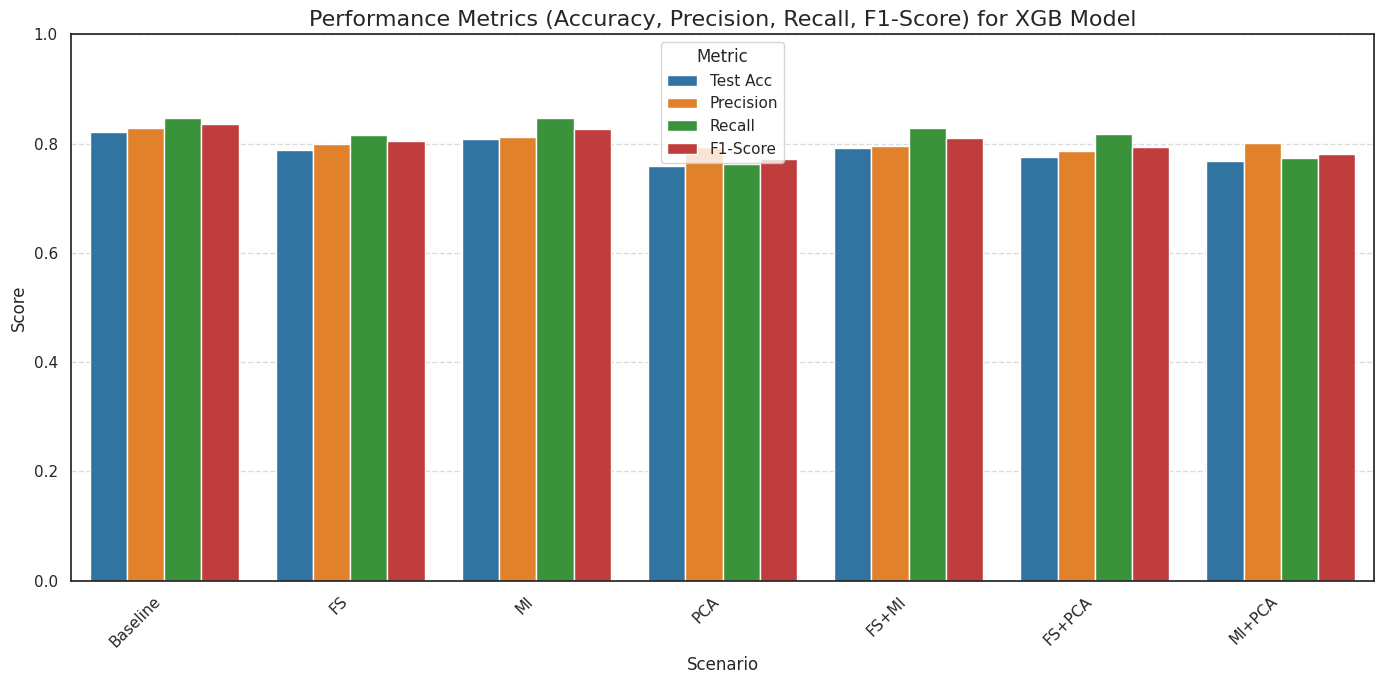

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Ensure 'Mean Acc' and 'Std Dev' columns are extracted if not already
if 'Mean Acc' not in df_final_results.columns or 'Std Dev' not in df_final_results.columns:
    def extract_mean_std(acc_str):
        match = re.match(r'([\d.]+) \(±([\d.]+)\)', acc_str)
        if match:
            return float(match.group(1)), float(match.group(2))
        return None, None
    df_final_results[['Mean Acc', 'Std Dev']] = df_final_results['Acc'].apply(lambda x: pd.Series(extract_mean_std(x)))

# Filter data for XGB model
df_xgb_metrics = df_final_results[df_final_results['Model'] == 'XGB'].copy()

# Convert 'Mean Acc' to decimal for consistent plotting (no division by 100 needed if already decimal)
df_xgb_metrics['Test Acc'] = df_xgb_metrics['Mean Acc'] # Corrected: Removed / 100.0

# Extract numeric values from string columns and convert to decimal (these are already floats)
df_xgb_metrics['Precision'] = df_xgb_metrics['Precision'].astype(float)
df_xgb_metrics['Recall'] = df_xgb_metrics['Recall'].astype(float)
df_xgb_metrics['F1-Score'] = df_xgb_metrics['F1'].astype(float)

# Select relevant metric columns
metrics_to_plot = ['Test Acc', 'Precision', 'Recall', 'F1-Score']

# Melt the DataFrame to long format for easy plotting
df_xgb_melted = df_xgb_metrics.melt(id_vars=['Skenario'],
                                      value_vars=metrics_to_plot,
                                      var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 7))
sns.barplot(x='Skenario', y='Score', hue='Metric', data=df_xgb_melted, palette='tab10')
plt.title('Performance Metrics (Accuracy, Precision, Recall, F1-Score) for XGB Model', fontsize=16)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0) # Metrics typically range from 0 to 1
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

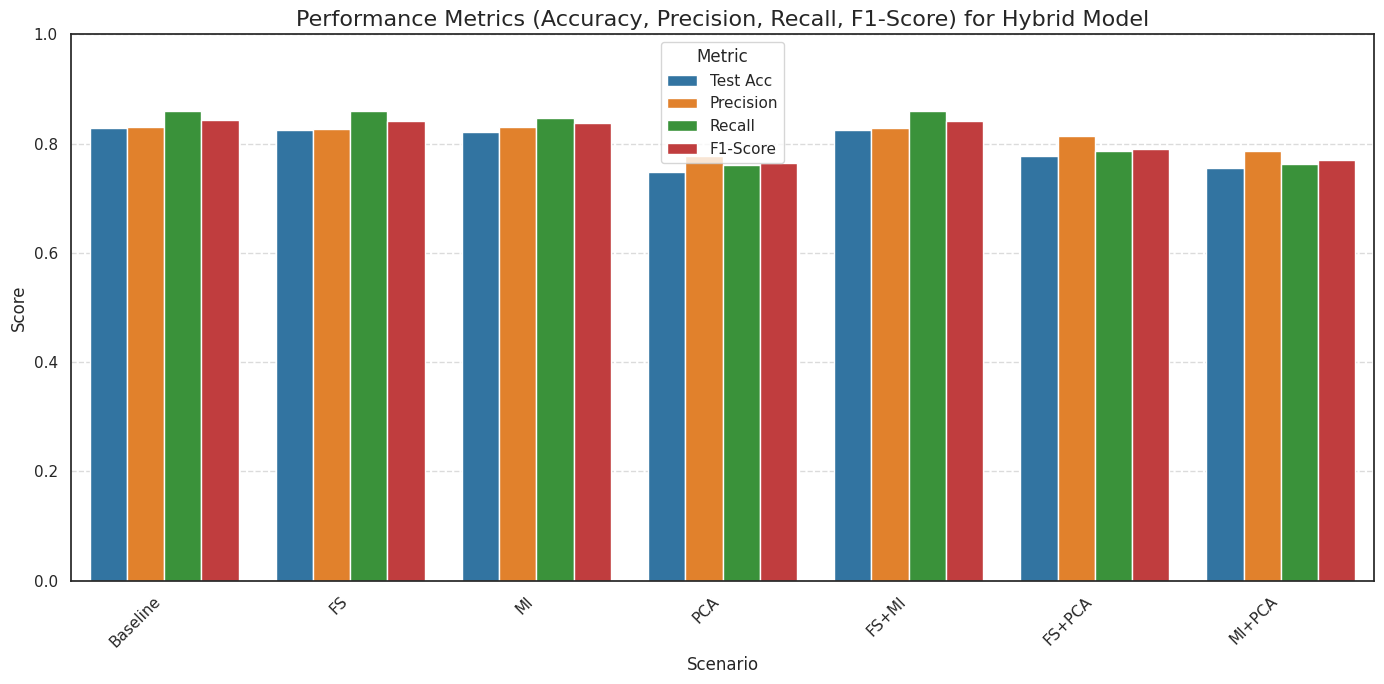

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Ensure 'Mean Acc' and 'Std Dev' columns are extracted if not already
if 'Mean Acc' not in df_final_results.columns or 'Std Dev' not in df_final_results.columns:
    def extract_mean_std(acc_str):
        match = re.match(r'([\d.]+) \(±([\d.]+)\)', acc_str)
        if match:
            return float(match.group(1)), float(match.group(2))
        return None, None
    df_final_results[['Mean Acc', 'Std Dev']] = df_final_results['Acc'].apply(lambda x: pd.Series(extract_mean_std(x)))

# Filter data for Hybrid model
df_hybrid_metrics = df_final_results[df_final_results['Model'] == 'Hybrid'].copy()

# Convert 'Mean Acc' to decimal for consistent plotting (no division by 100 needed if already decimal)
df_hybrid_metrics['Test Acc'] = df_hybrid_metrics['Mean Acc'] # Corrected: Removed / 100.0

# Extract numeric values from string columns and convert to decimal (these are already floats)
df_hybrid_metrics['Precision'] = df_hybrid_metrics['Precision'].astype(float)
df_hybrid_metrics['Recall'] = df_hybrid_metrics['Recall'].astype(float)
df_hybrid_metrics['F1-Score'] = df_hybrid_metrics['F1'].astype(float)

# Select relevant metric columns
metrics_to_plot = ['Test Acc', 'Precision', 'Recall', 'F1-Score']

# Melt the DataFrame to long format for easy plotting
df_hybrid_melted = df_hybrid_metrics.melt(id_vars=['Skenario'],
                                      value_vars=metrics_to_plot,
                                      var_name='Metric', value_name='Score')

plt.figure(figsize=(14, 7))
sns.barplot(x='Skenario', y='Score', hue='Metric', data=df_hybrid_melted, palette='tab10')
plt.title('Performance Metrics (Accuracy, Precision, Recall, F1-Score) for Hybrid Model', fontsize=16)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1.0) # Metrics typically range from 0 to 1
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **CONFUSSION MATRIX**

In [58]:
import pandas as pd

# Membuat DataFrame khusus untuk analisis Confusion Matrix
df_cm = pd.DataFrame(df_final_results)

# Memilih kolom-kolom yang relevan untuk Confusion Matrix
cols_cm = ['Skenario', 'Model', 'TN', 'FP', 'FN', 'TP']
tabel_cm = df_cm[cols_cm].copy()

# Menambahkan kolom Total Data sebagai verifikasi
tabel_cm['Total'] = tabel_cm['TN'] + tabel_cm['FP'] + tabel_cm['FN'] + tabel_cm['TP']

# Menampilkan tabel
print("--- TABEL ANALISIS CONFUSION MATRIX SELURUH SKENARIO ---")
display(tabel_cm)


--- TABEL ANALISIS CONFUSION MATRIX SELURUH SKENARIO ---


,Skenario,Model,TN,FP,FN,TP,Total
0,Baseline,ETC,109,29,23,141,302
1,Baseline,XGB,109,29,25,139,302
2,Baseline,Hybrid,109,29,23,141,302
3,FS,ETC,108,30,23,141,302
4,FS,XGB,104,34,30,134,302
5,FS,Hybrid,108,30,23,141,302
6,MI,ETC,109,29,25,139,302
7,MI,XGB,105,33,25,139,302
8,MI,Hybrid,109,29,25,139,302
9,PCA,ETC,101,37,39,125,302


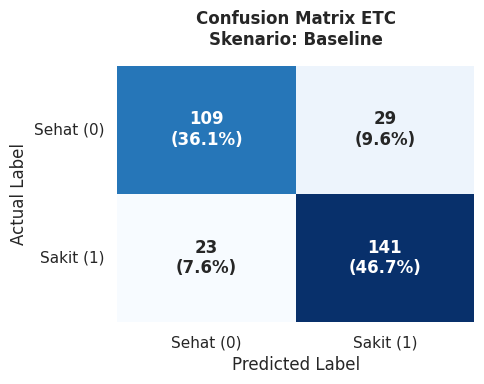

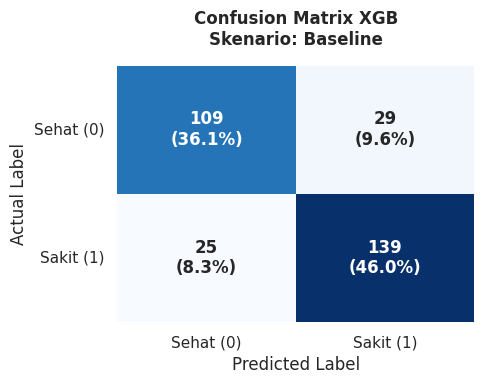

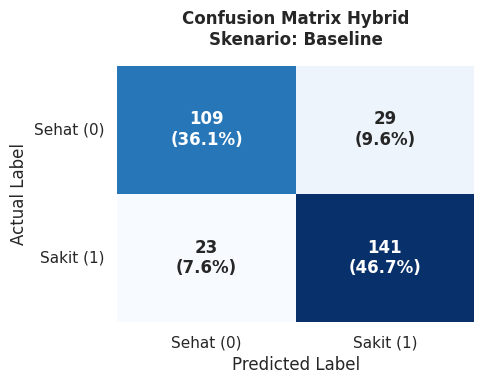

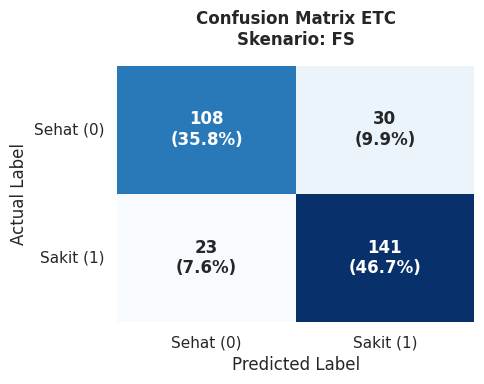

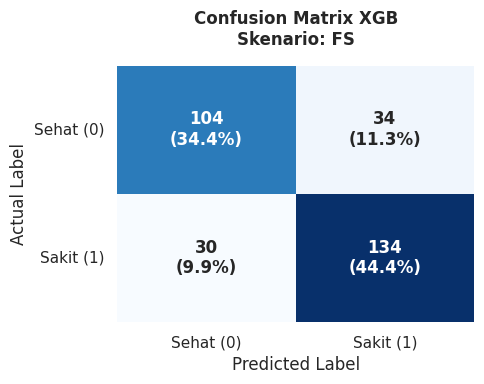

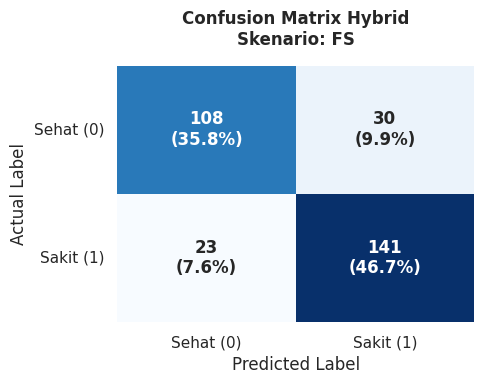

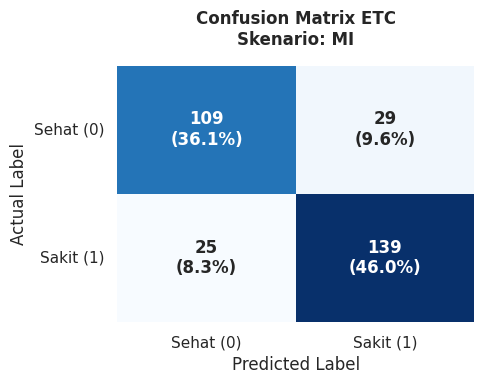

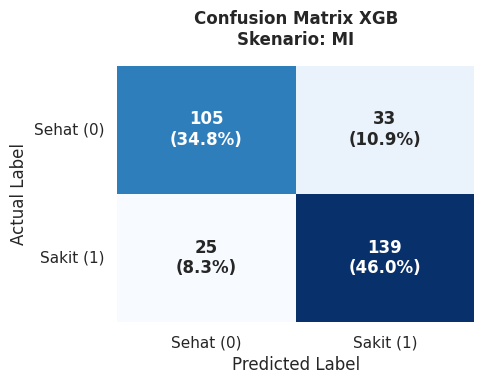

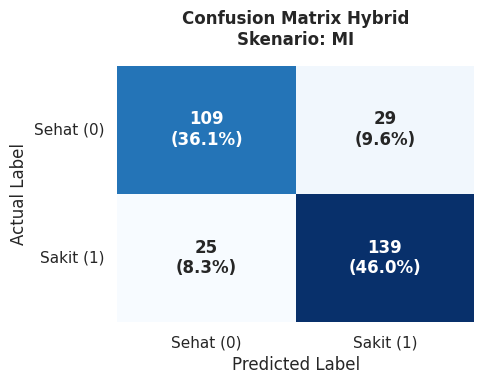

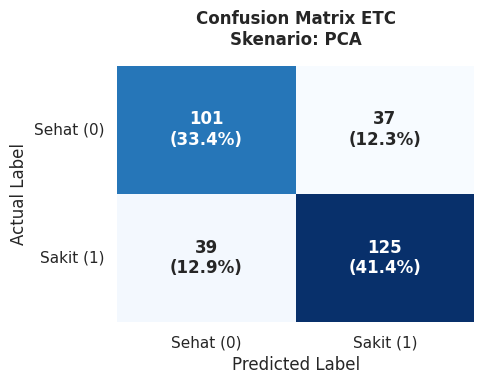

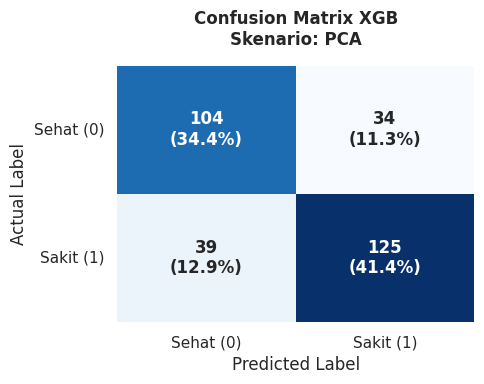

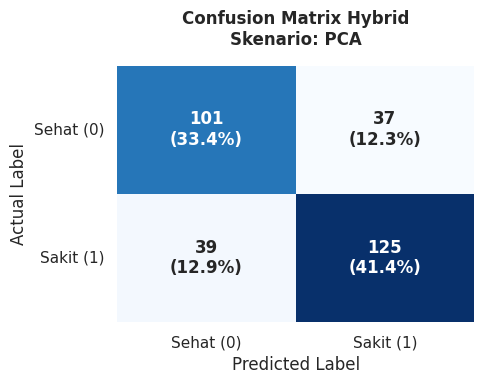

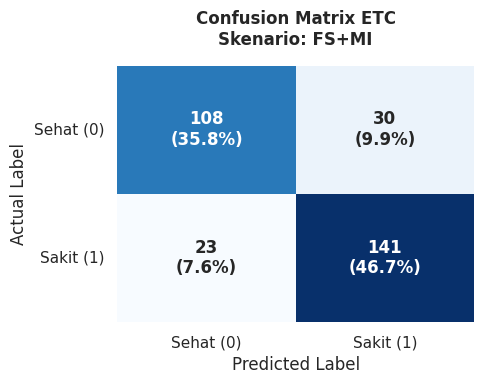

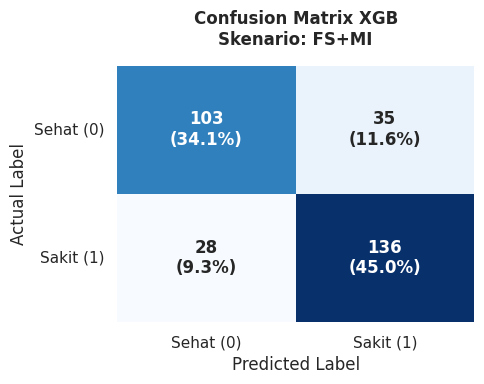

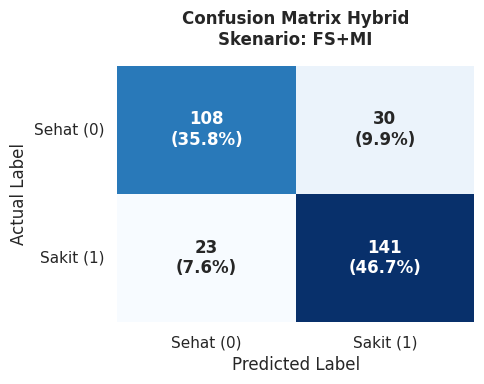

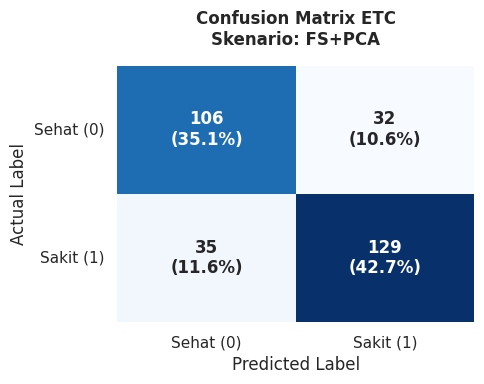

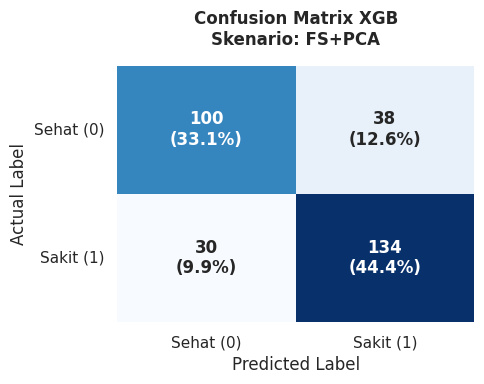

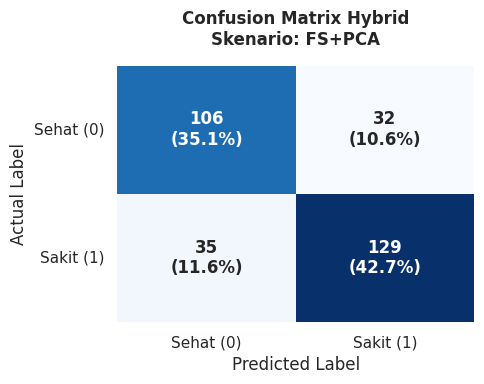

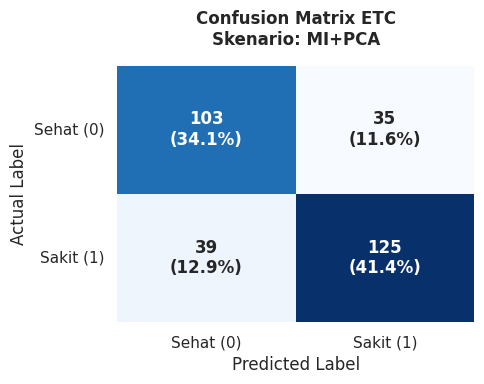

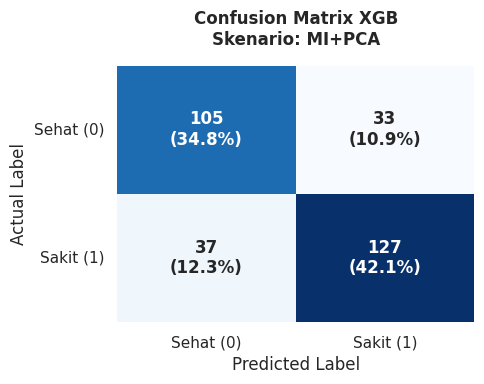

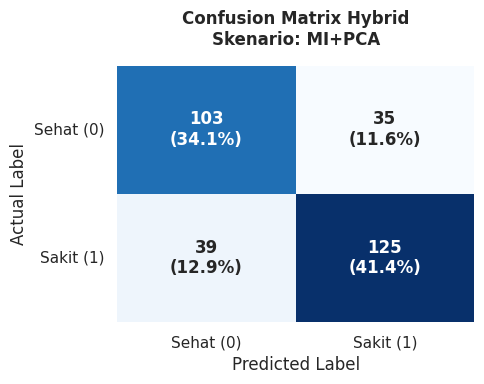

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_individual_confusion_matrices(df_results):
    # Mengambil daftar unik skenario
    scenarios = df_results['Skenario'].unique()

    for s_name in scenarios:
        # Filter data untuk skenario tersebut
        data_scenario = df_results[df_results['Skenario'] == s_name]

        models = ['ETC', 'XGB', 'Hybrid']

        for model_name in models:
            # Ambil baris data spesifik model
            row = data_scenario[data_scenario['Model'] == model_name].iloc[0]

            # Susun matriks
            cm = np.array([[int(row['TN']), int(row['FP'])],
                           [int(row['FN']), int(row['TP'])]])

            # Hitung persentase
            cm_perc = cm.astype('float') / cm.sum() * 100
            labels = [f"{v:d}\n({p:.1f}%)" for v, p in zip(cm.flatten(), cm_perc.flatten())]
            labels = np.array(labels).reshape(2,2)

            # Buat figure baru untuk setiap model agar bisa di-copy satu per satu
            plt.figure(figsize=(5, 4))

            sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False,
                        annot_kws={"size": 12, "fontweight": "bold"})

            # Judul yang spesifik untuk memudahkan copy-paste
            plt.title(f'Confusion Matrix {model_name}\nSkenario: {s_name}',
                      fontsize=12, fontweight='bold', pad=15)

            plt.xlabel('Predicted Label')
            plt.ylabel('Actual Label')
            plt.xticks([0.5, 1.5], ['Sehat (0)', 'Sakit (1)'])
            plt.yticks([0.5, 1.5], ['Sehat (0)', 'Sakit (1)'], rotation=0)

            plt.tight_layout()

            # Menampilkan gambar satu per satu
            plt.show()

# Jalankan fungsi
plot_individual_confusion_matrices(df_final_results)


## **ROC-AUC**

Membuat Grafik ROC Curve untuk setiap Skenario...



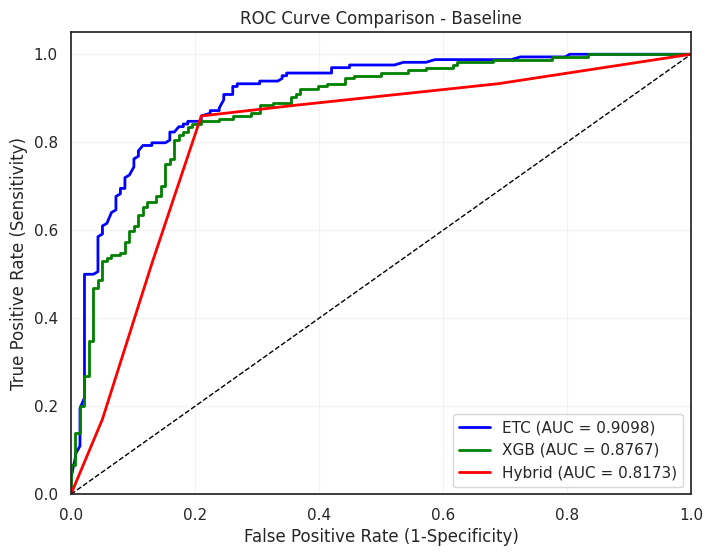

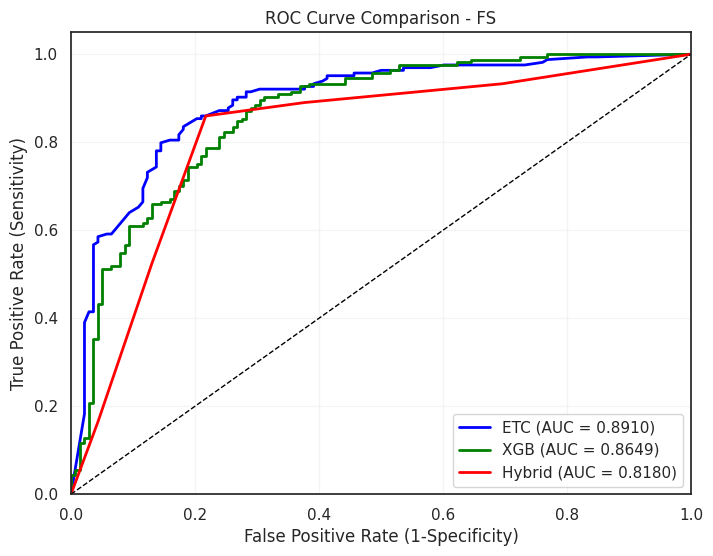

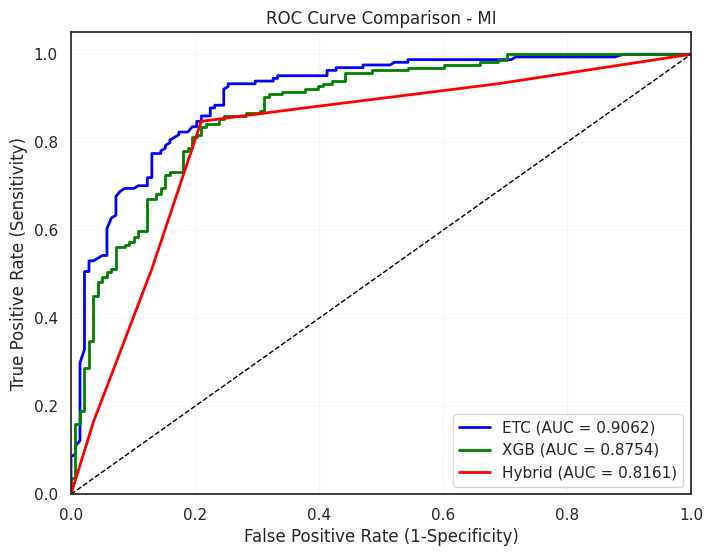

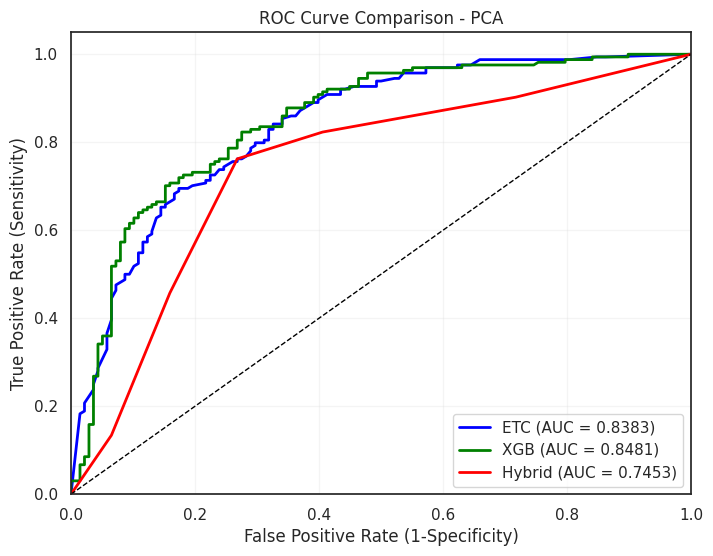

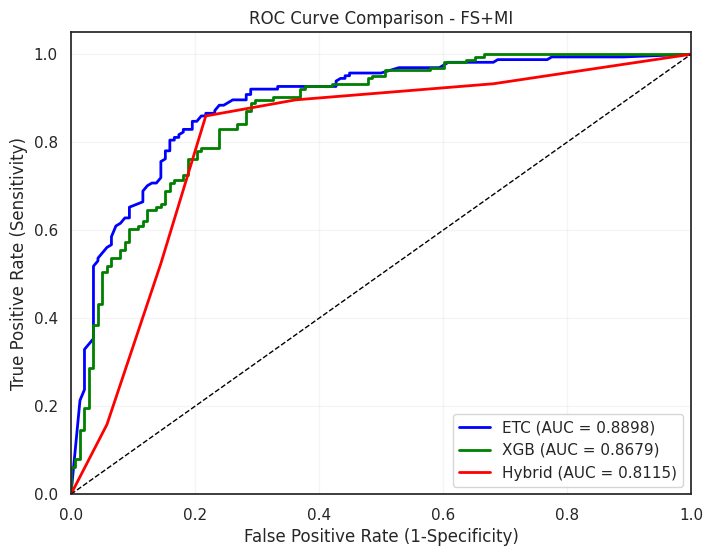

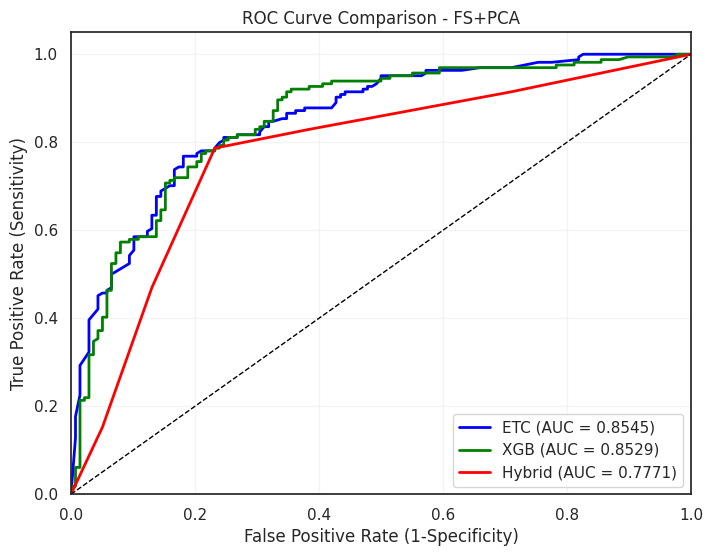

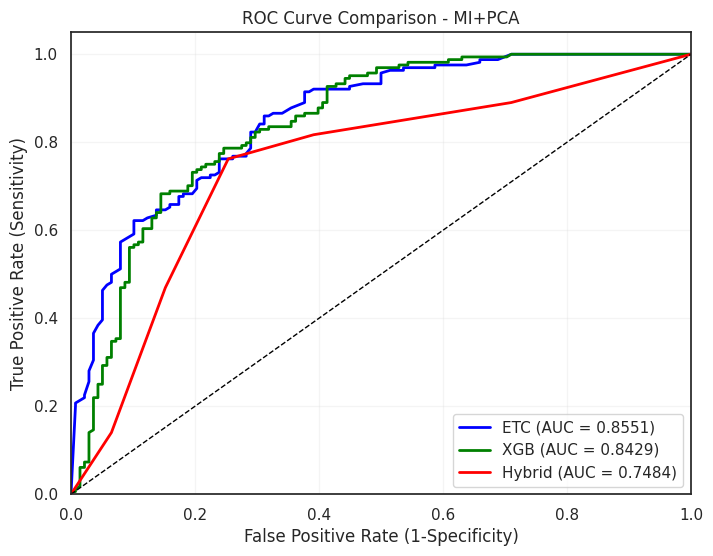

In [60]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt # Ensure matplotlib is imported

def plot_roc_per_scenario(y_true, prob_etc, prob_xgb, prob_hyb, scenario_name):
    plt.figure(figsize=(8, 6))

    models_prob = {
        'ETC': prob_etc,
        'XGB': prob_xgb,
        'Hybrid': prob_hyb
    }

    colors = ['blue', 'green', 'red']

    for (m_name, m_prob), color in zip(models_prob.items(), colors):
        # Ensure probabilities are not empty or all NaNs
        if m_prob and all(isinstance(p, (int, float, np.number)) and not np.isnan(p) for p in m_prob): # Check if m_prob contains valid numbers
            fpr, tpr, _ = roc_curve(y_true, m_prob)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, color=color, lw=2, label=f'{m_name} (AUC = {roc_auc:.4f})')
        else:
            print(f"Warning: Skipping {m_name} for {scenario_name} due to invalid probabilities.")

    plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title(f'ROC Curve Comparison - {scenario_name}')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.2)
    plt.show()

# --- 4. Plotting Grafik ROC ---
# The roc_data_storage variable needs to be populated during the model training loop.
# I will execute the main training loop first to ensure this data is available.

print("Membuat Grafik ROC Curve untuk setiap Skenario...\n")

# You need to run the main model training cell (7UdaEHTC2-Qw) first to populate roc_data_storage
# Assuming roc_data_storage is populated after running 7UdaEHTC2-Qw
# For demonstration, let's assume roc_data_storage is available.

# Iterate through all scenarios in roc_data_storage and plot their ROC curves
for scenario_name, data in roc_data_storage.items():
    # Ambil data yang sudah disimpan
    y_true = data['y_true']
    p_etc = data['prob_etc']
    p_xgb = data['prob_xgb']
    p_hyb = data['prob_hyb']

    # Panggil fungsi plot
    plot_roc_per_scenario(y_true, p_etc, p_xgb, p_hyb, scenario_name)


## **STANDAR DEVIASI**

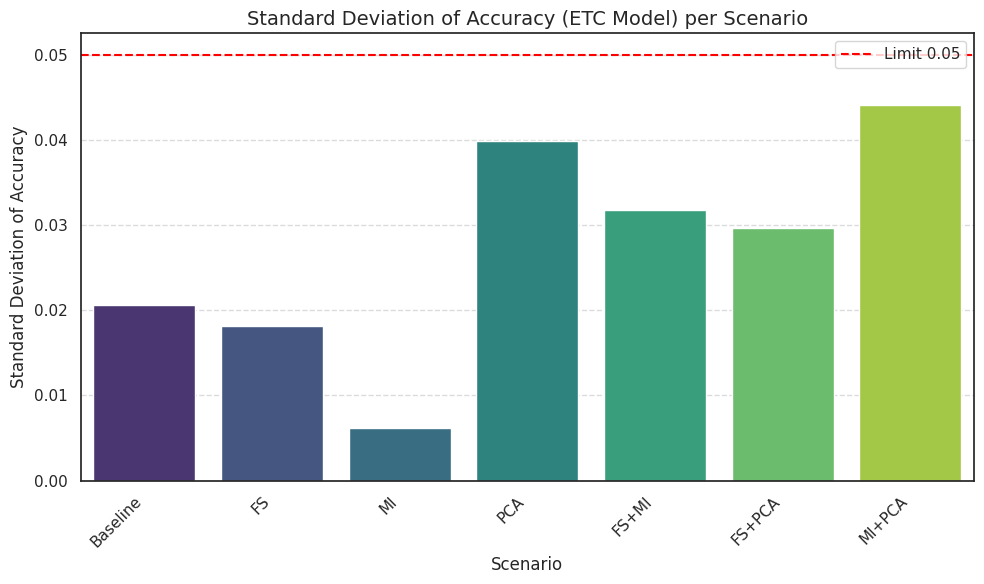

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Extract mean and std from 'Acc' column
def extract_mean_std_from_acc(acc_str):
    match = re.match(r'([\d.]+) \(±([\d.]+)\)', acc_str)
    if match:
        return float(match.group(1)), float(match.group(2))
    return None, None

df_final_results[['Mean Acc', 'Std Dev']] = df_final_results['Acc'].apply(lambda x: pd.Series(extract_mean_std_from_acc(x)))

# Filter for ETC model
df_etc_std = df_final_results[df_final_results['Model'] == 'ETC'].copy()

plt.figure(figsize=(10, 6))
sns.barplot(x='Skenario', y='Std Dev', data=df_etc_std, palette='viridis', hue='Skenario', legend=False)
plt.axhline(y=0.05, color='red', linestyle='--', label='Limit 0.05')
plt.title('Standard Deviation of Accuracy (ETC Model) per Scenario', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Standard Deviation of Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

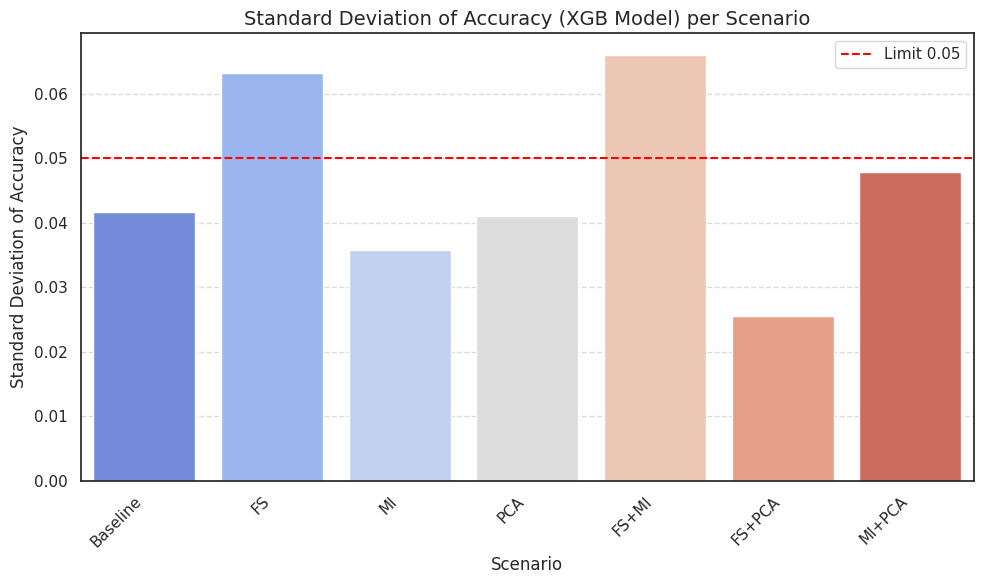

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Ensure 'Mean Acc' and 'Std Dev' columns are extracted if not already
if 'Mean Acc' not in df_final_results.columns or 'Std Dev' not in df_final_results.columns:
    def extract_mean_std_from_acc(acc_str):
        match = re.match(r'([\d.]+) \(±([\d.]+)\)', acc_str)
        if match:
            return float(match.group(1)), float(match.group(2))
        return None, None
    df_final_results[['Mean Acc', 'Std Dev']] = df_final_results['Acc'].apply(lambda x: pd.Series(extract_mean_std_from_acc(x)))

# Filter for XGB model
df_xgb_std = df_final_results[df_final_results['Model'] == 'XGB'].copy()

plt.figure(figsize=(10, 6))
sns.barplot(x='Skenario', y='Std Dev', data=df_xgb_std, palette='coolwarm', hue='Skenario', legend=False)
plt.axhline(y=0.05, color='red', linestyle='--', label='Limit 0.05')
plt.title('Standard Deviation of Accuracy (XGB Model) per Scenario', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Standard Deviation of Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

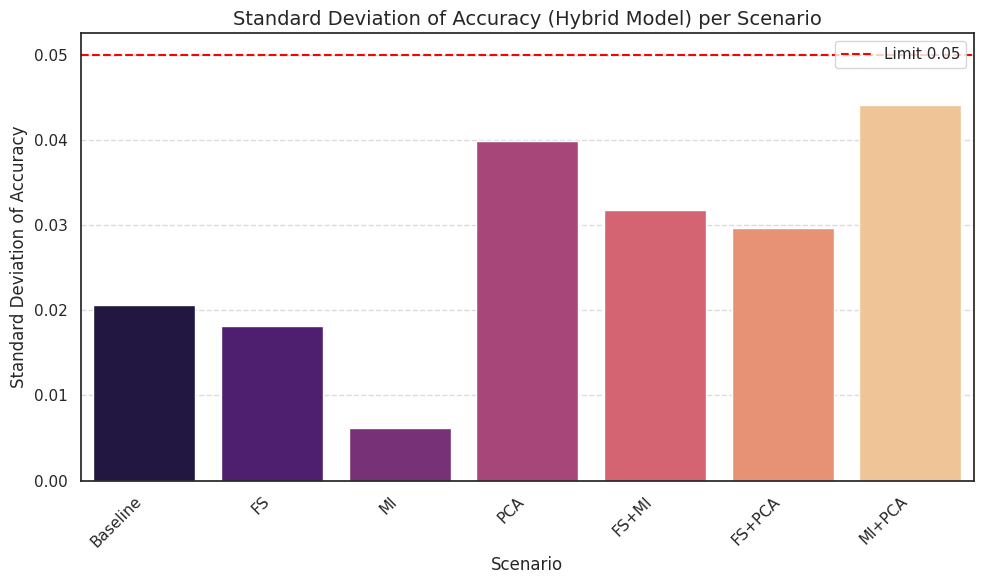

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

# Ensure 'Mean Acc' and 'Std Dev' columns are extracted if not already
if 'Mean Acc' not in df_final_results.columns or 'Std Dev' not in df_final_results.columns:
    def extract_mean_std_from_acc(acc_str):
        match = re.match(r'([\d.]+) \(±([\d.]+)\)', acc_str)
        if match:
            return float(match.group(1)), float(match.group(2))
        return None, None
    df_final_results[['Mean Acc', 'Std Dev']] = df_final_results['Acc'].apply(lambda x: pd.Series(extract_mean_std_from_acc(x)))

# Filter for Hybrid model
df_hybrid_std = df_final_results[df_final_results['Model'] == 'Hybrid'].copy()

plt.figure(figsize=(10, 6))
sns.barplot(x='Skenario', y='Std Dev', data=df_hybrid_std, palette='magma', hue='Skenario', legend=False)
plt.axhline(y=0.05, color='red', linestyle='--', label='Limit 0.05')
plt.title('Standard Deviation of Accuracy (Hybrid Model) per Scenario', fontsize=14)
plt.xlabel('Scenario', fontsize=12)
plt.ylabel('Standard Deviation of Accuracy', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()